# Imports

In [1]:
import yfinance        as yf
import seaborn         as sns
import numpy           as np
import pandas          as pd
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve, mean_squared_error

from matplotlib              import pyplot as plt
from pandas_datareader       import data   as pdr
from IPython.core.display    import HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading data

In [3]:
yf.pdr_override()

In [4]:
start = '2000-01-01'
#end = '2019-12-31'
end = '2021-12-31'

data = pdr.get_data_yahoo( '^GSPC', start=start, end=end )

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,4778.729980,3124950000


# Data Description

In [7]:
df2 = data.copy()

In [8]:
df2.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Times Series Visualization

In [9]:
df3 = df2.copy()

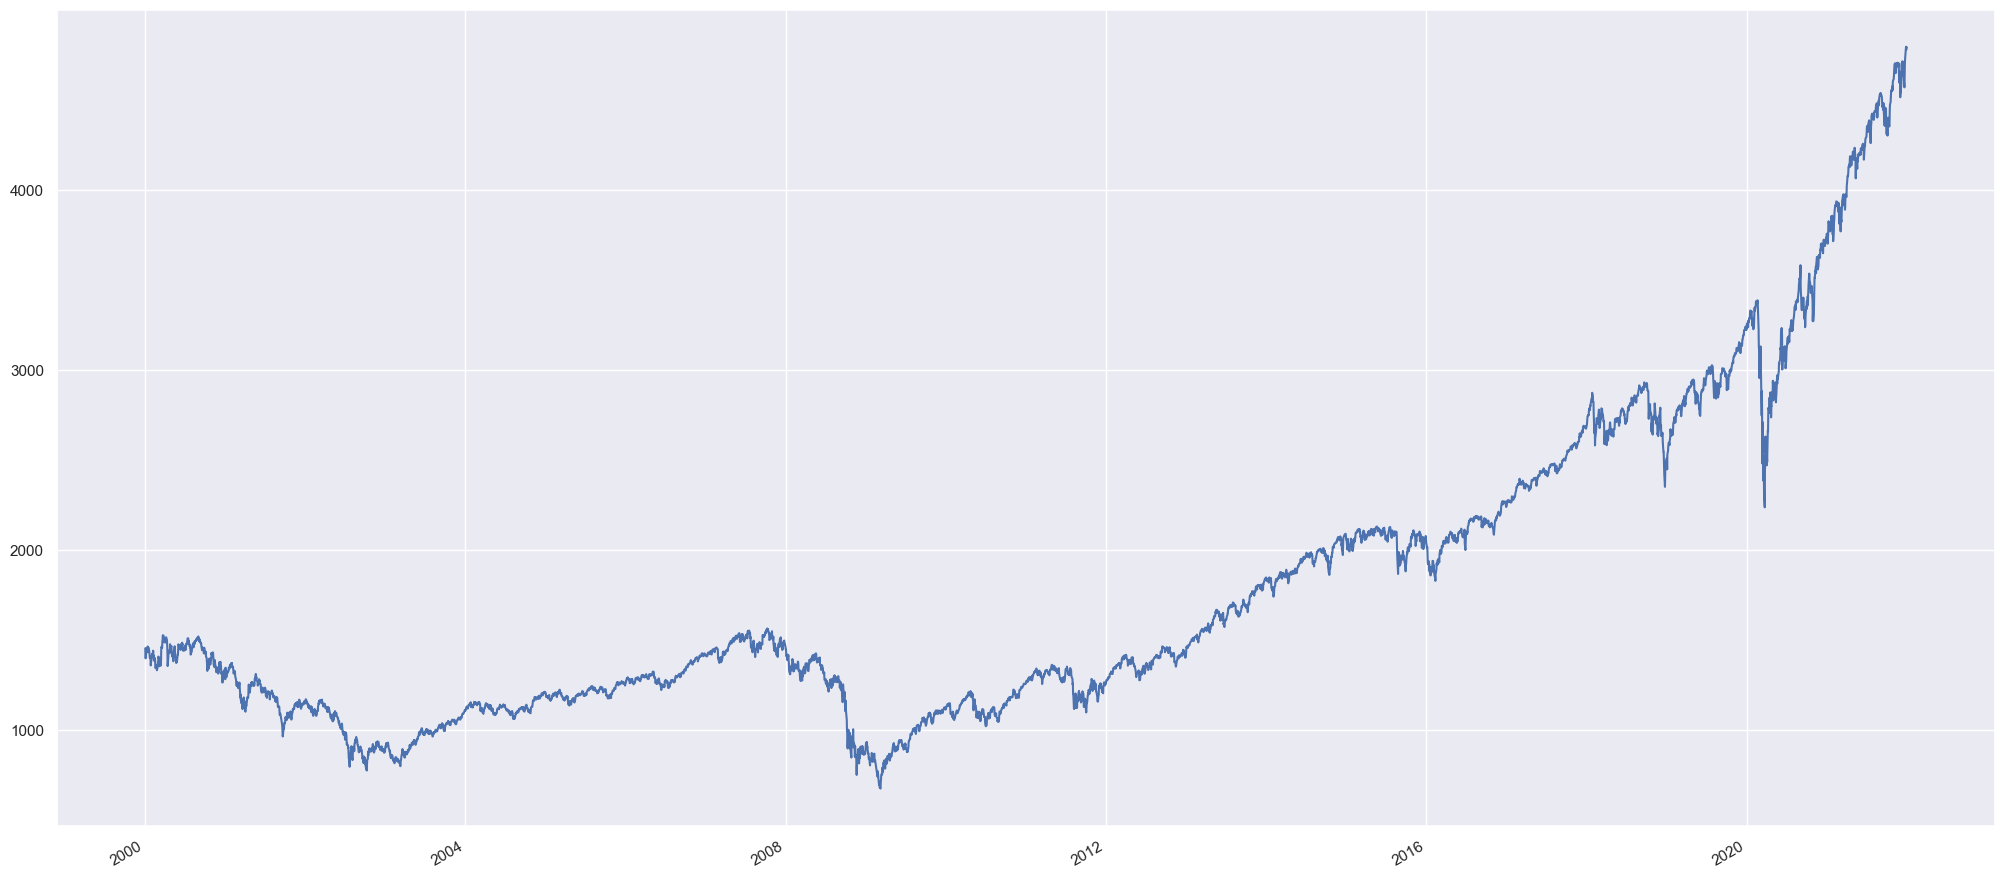

In [10]:
df3['Close'].plot()
#plt.title( 'Gráfico da Série S&P 500' );
plt.xlabel( '' );

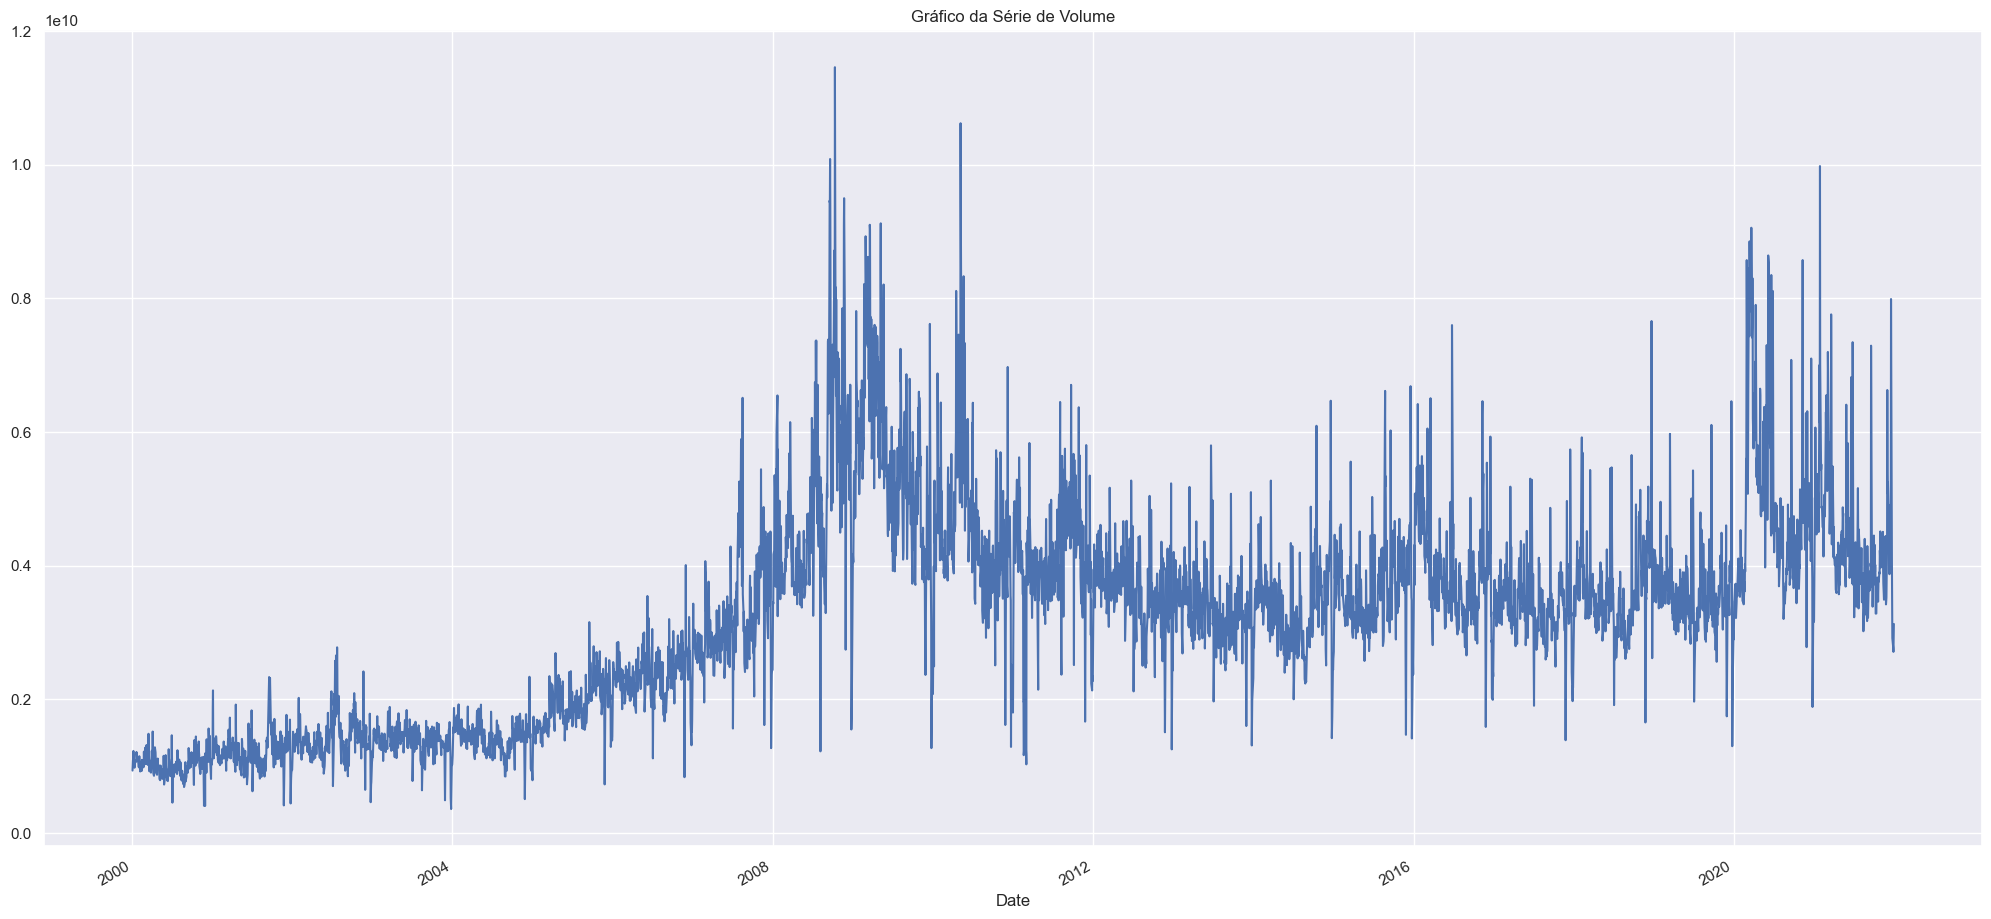

In [11]:
df3['Volume'].plot();
plt.title( 'Gráfico da Série de Volume' );

# Exploratory Data Analysis

In [12]:
df4 = df3.copy()

In [13]:
df4.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5.535000e+03
mean,1772.102924,1782.233612,1761.197519,1772.378729,1772.378729,3.237908e+09
std,856.734841,859.780494,853.671921,857.084851,857.084851,1.521928e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1173.785034,1182.119995,1166.144958,1173.805054,1173.805054,1.855095e+09
50%,1409.119995,1415.890015,1399.250000,1409.119995,1409.119995,3.349090e+09
75%,2123.404907,2130.660034,2115.059937,2125.030029,2125.030029,4.075415e+09
max,4795.490234,4808.930176,4780.040039,4793.060059,4793.060059,1.145623e+10


In [14]:
# lag de X periodos

periodos = 1

# lag positivo de X periodos
df4['Lag_P1'] = df4['Close'].shift( periodos )

In [15]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951


In [16]:
# Dummy para saber se o dia atual é Alta(1) ou Baixa(0)

df4['High_Low'] = np.where( df4['Close'] > df4['Lag_P1'], 1, 0 )

In [17]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1


In [18]:
df4['High_Low'].mean()

0.538572719060524

In [19]:
# Calculando o Retorno

df4['Retorno'] = df4['Close'].pct_change( periodos )

In [20]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090


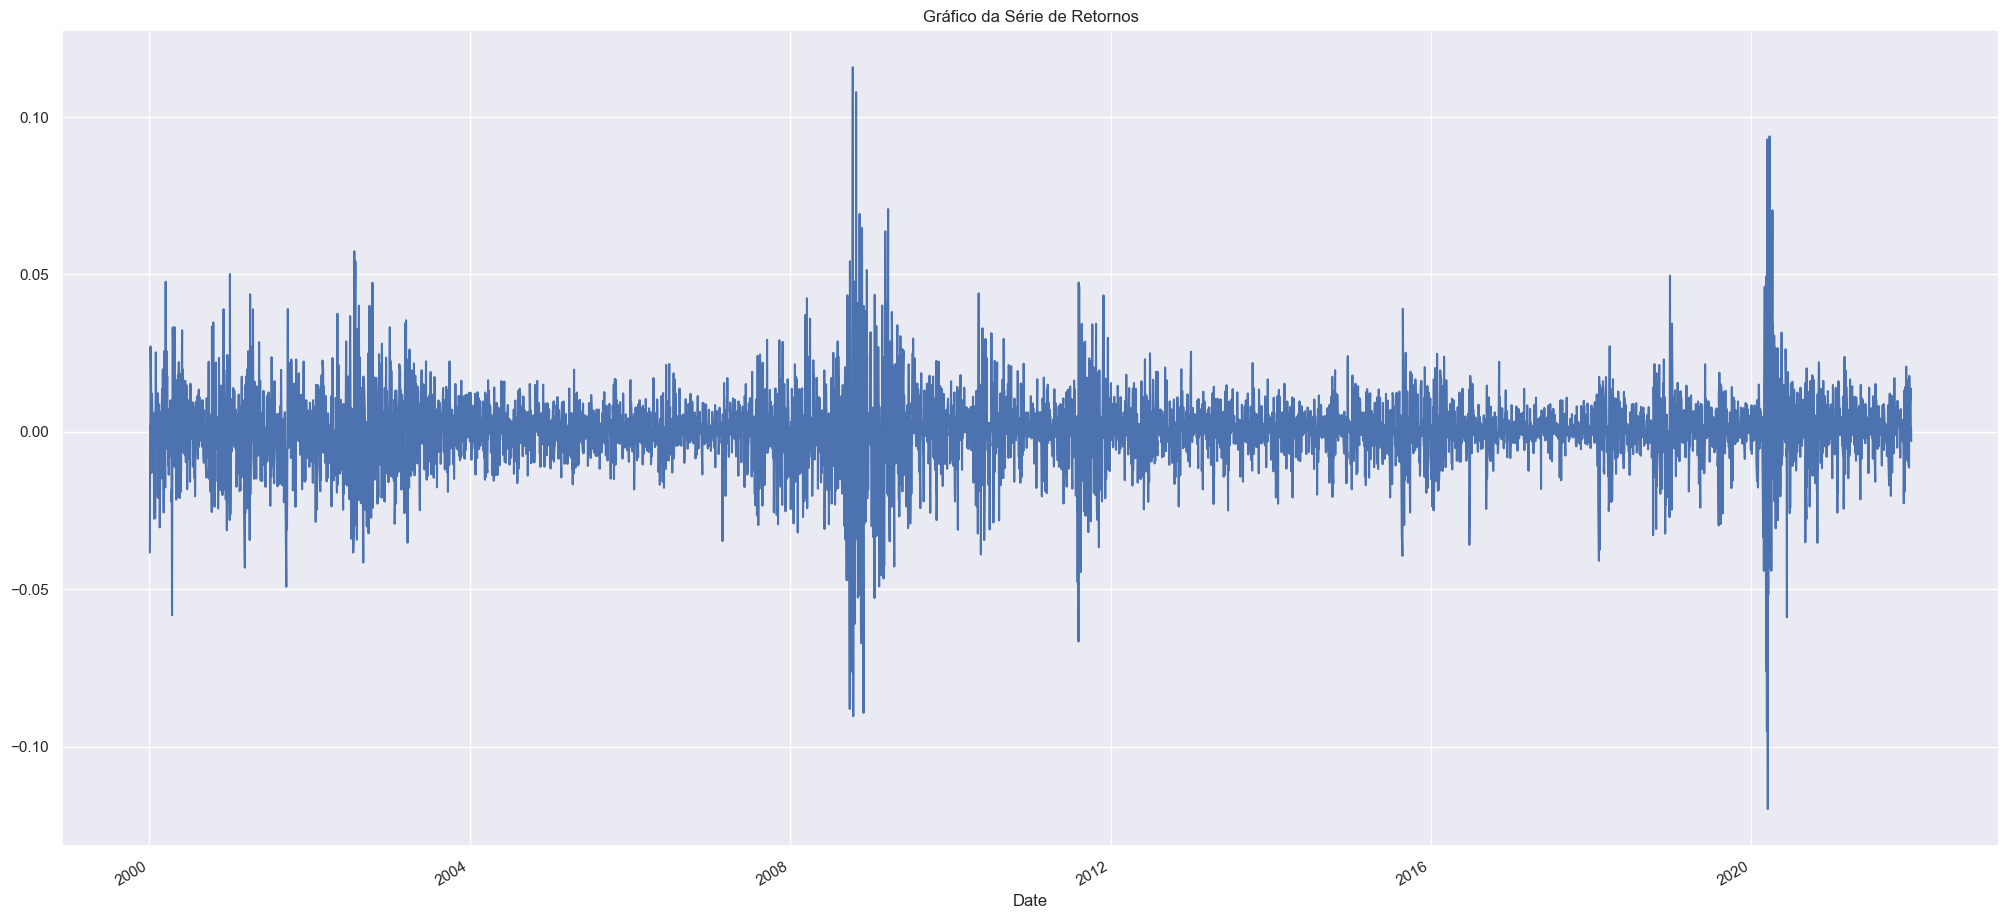

In [21]:
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

C:\Users\lucas\AppData\Local\Temp\ipykernel_4556\3695061061.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


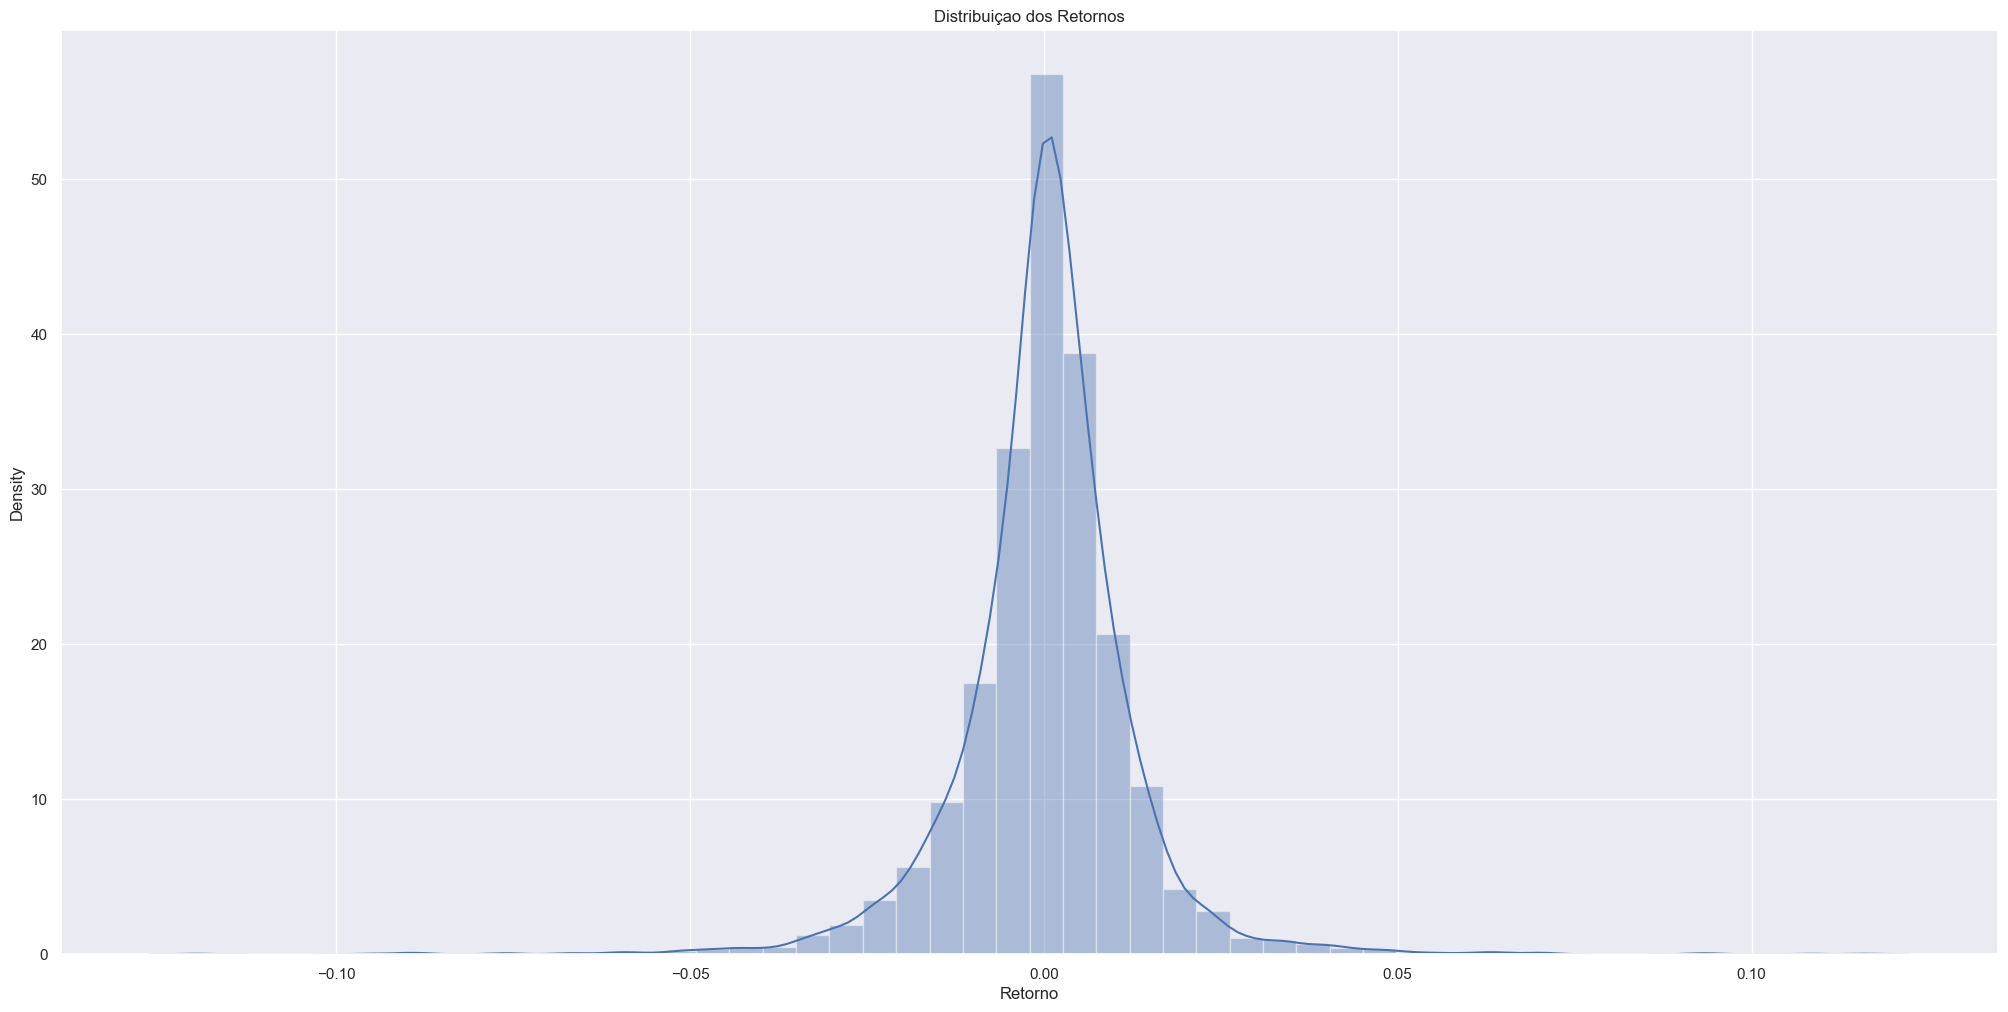

In [22]:
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

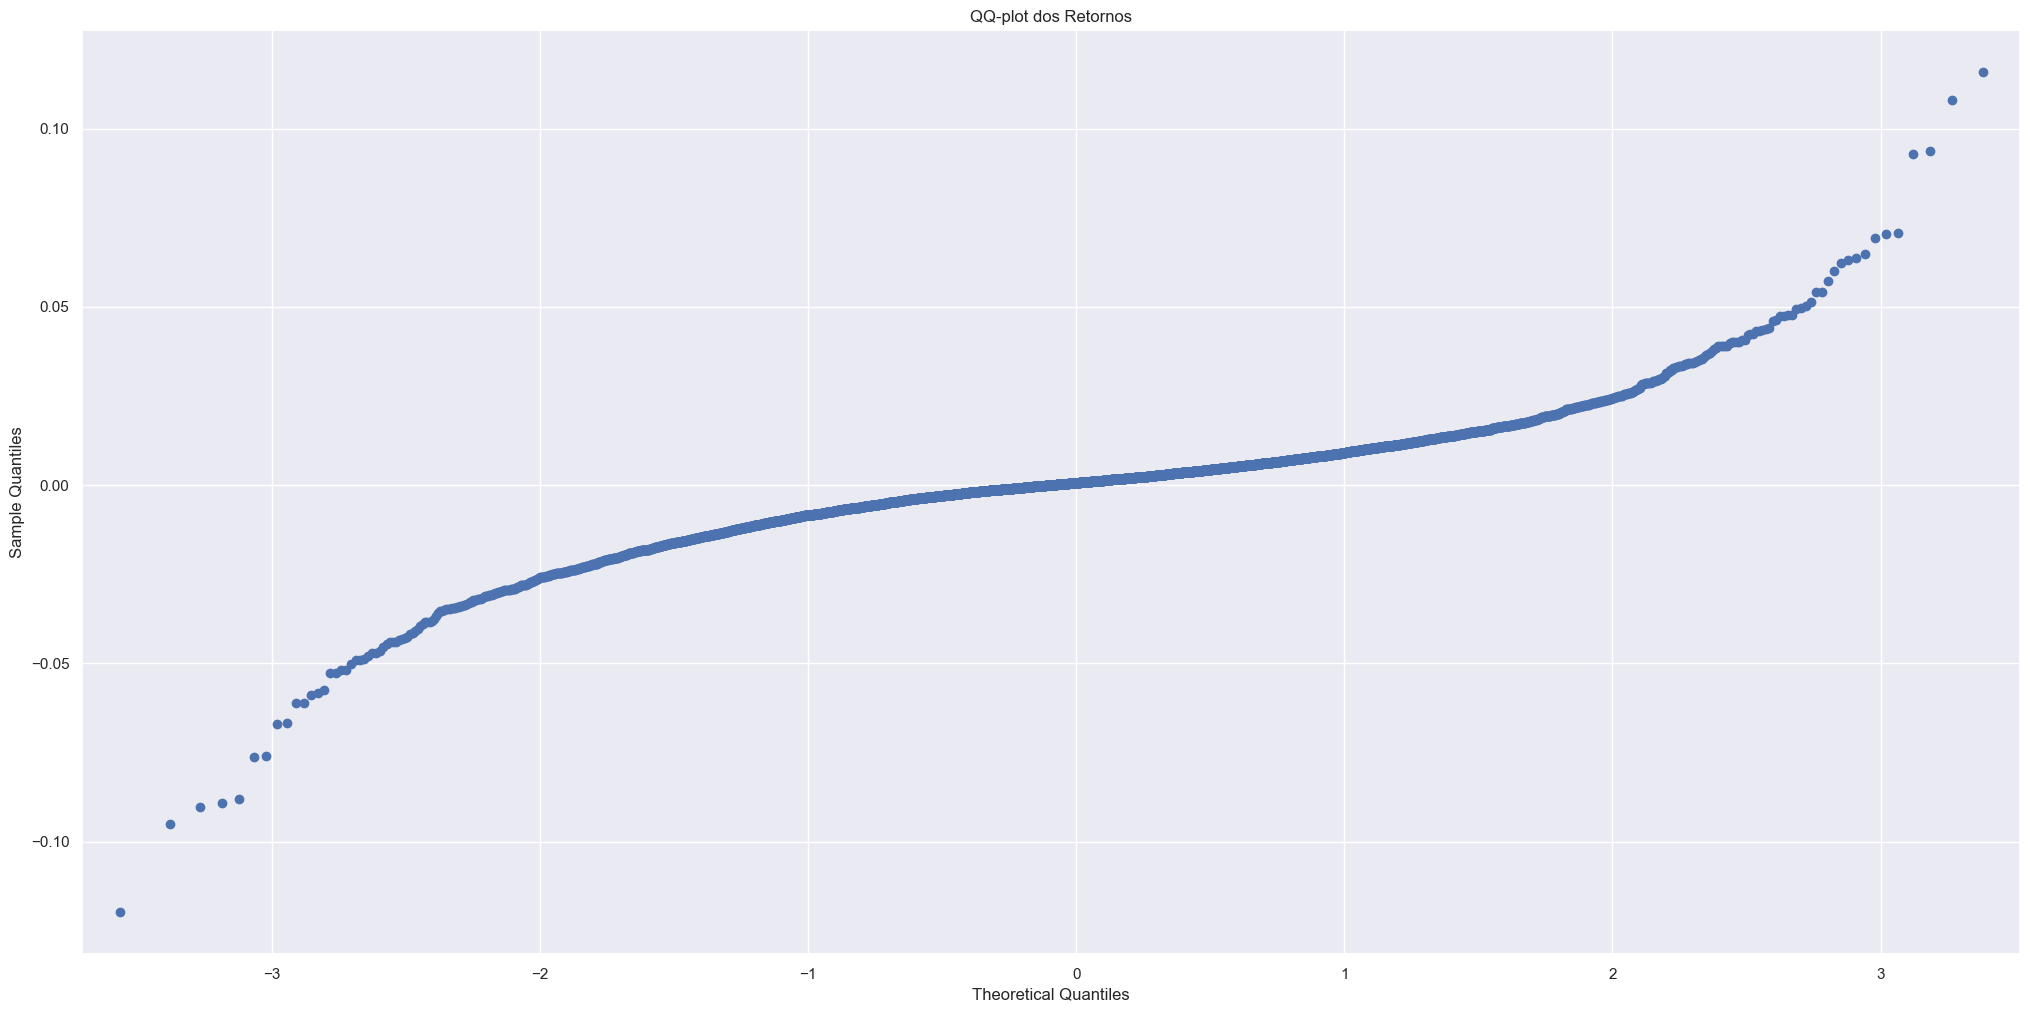

In [23]:
sm.qqplot( df4['Retorno'] )
plt.title( 'QQ-plot dos Retornos' );

Consolidando os gráficos da série histórica, série de retornos, distribuição dos retornos e qq-plot em uma mesma imagem.

C:\Users\lucas\AppData\Local\Temp\ipykernel_4556\3273338487.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


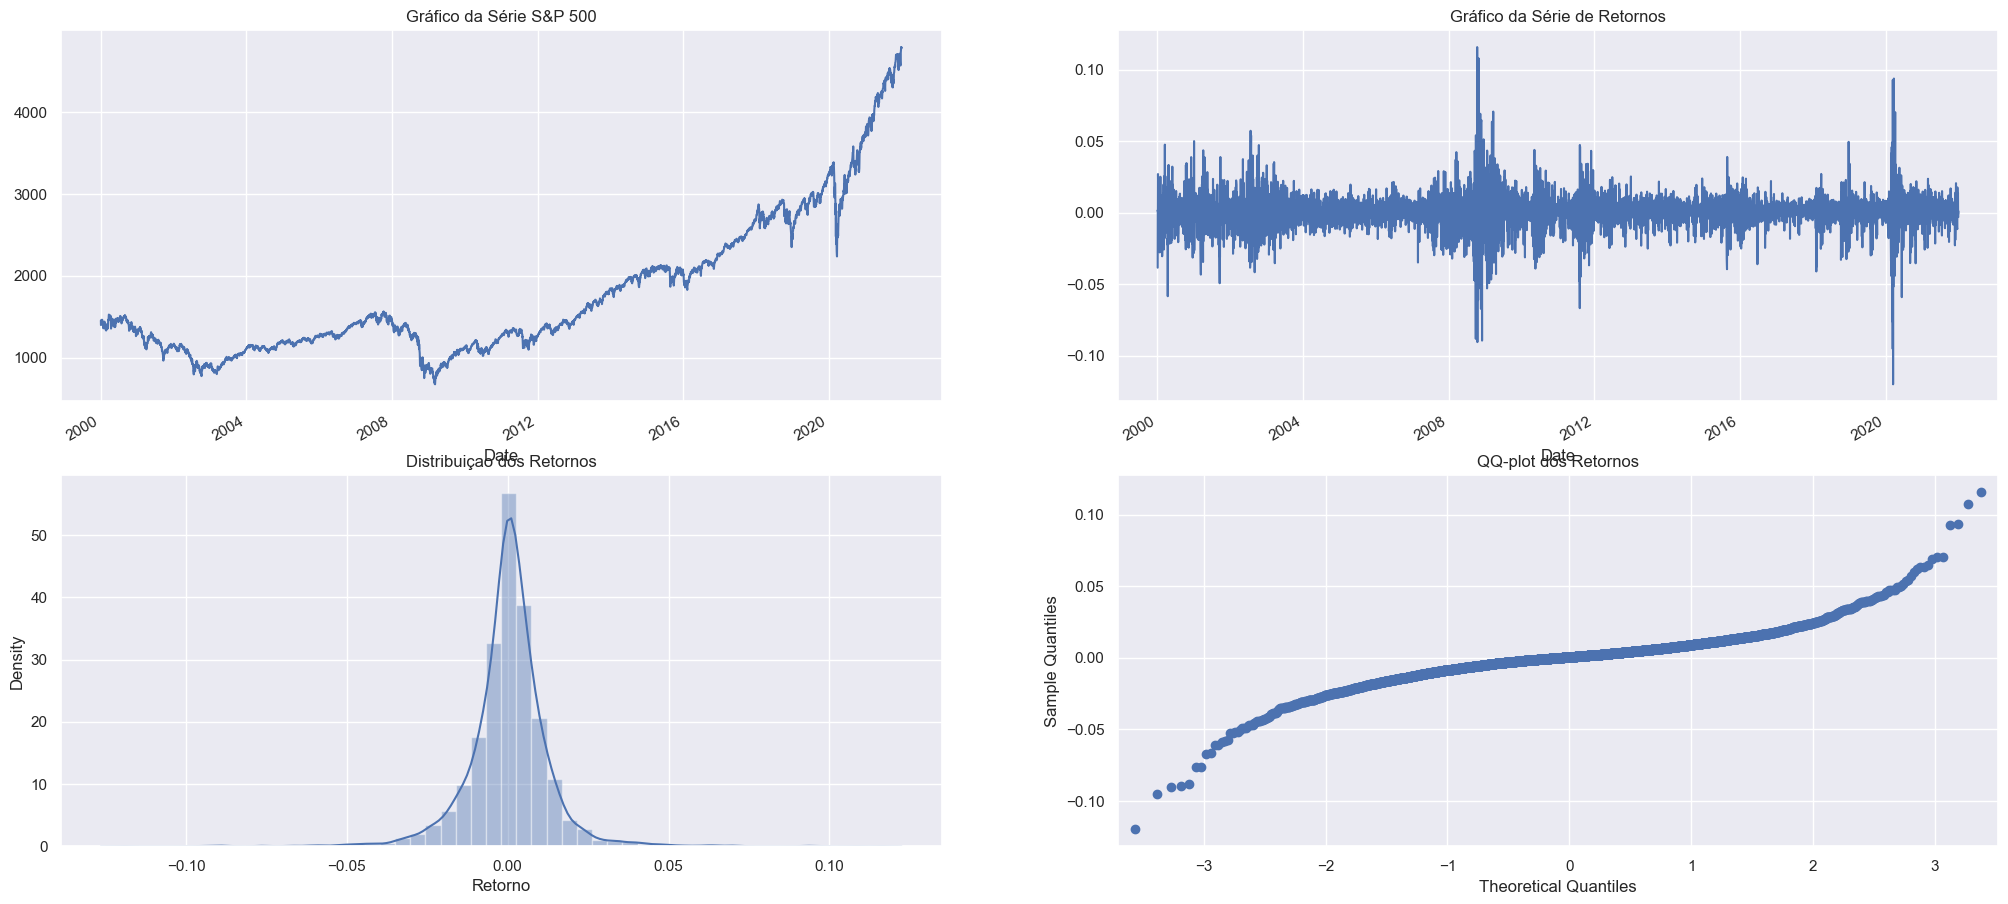

In [24]:
plt.subplot( 2, 2, 1 )
df3['Close'].plot()
plt.title( 'Gráfico da Série S&P 500' );

plt.subplot( 2, 2, 2 )
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

plt.subplot( 2, 2, 3 )
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

#plt.subplot( 2, 2, 4 )
sm.qqplot( df4['Retorno'], ax=plt.subplot( 2, 2, 4 ) ) 
plt.title( 'QQ-plot dos Retornos' );

In [25]:
df4['Retorno'].describe()

count    5534.000000
mean        0.000292
std         0.012370
min        -0.119841
25%        -0.004695
50%         0.000639
75%         0.005830
max         0.115800
Name: Retorno, dtype: float64

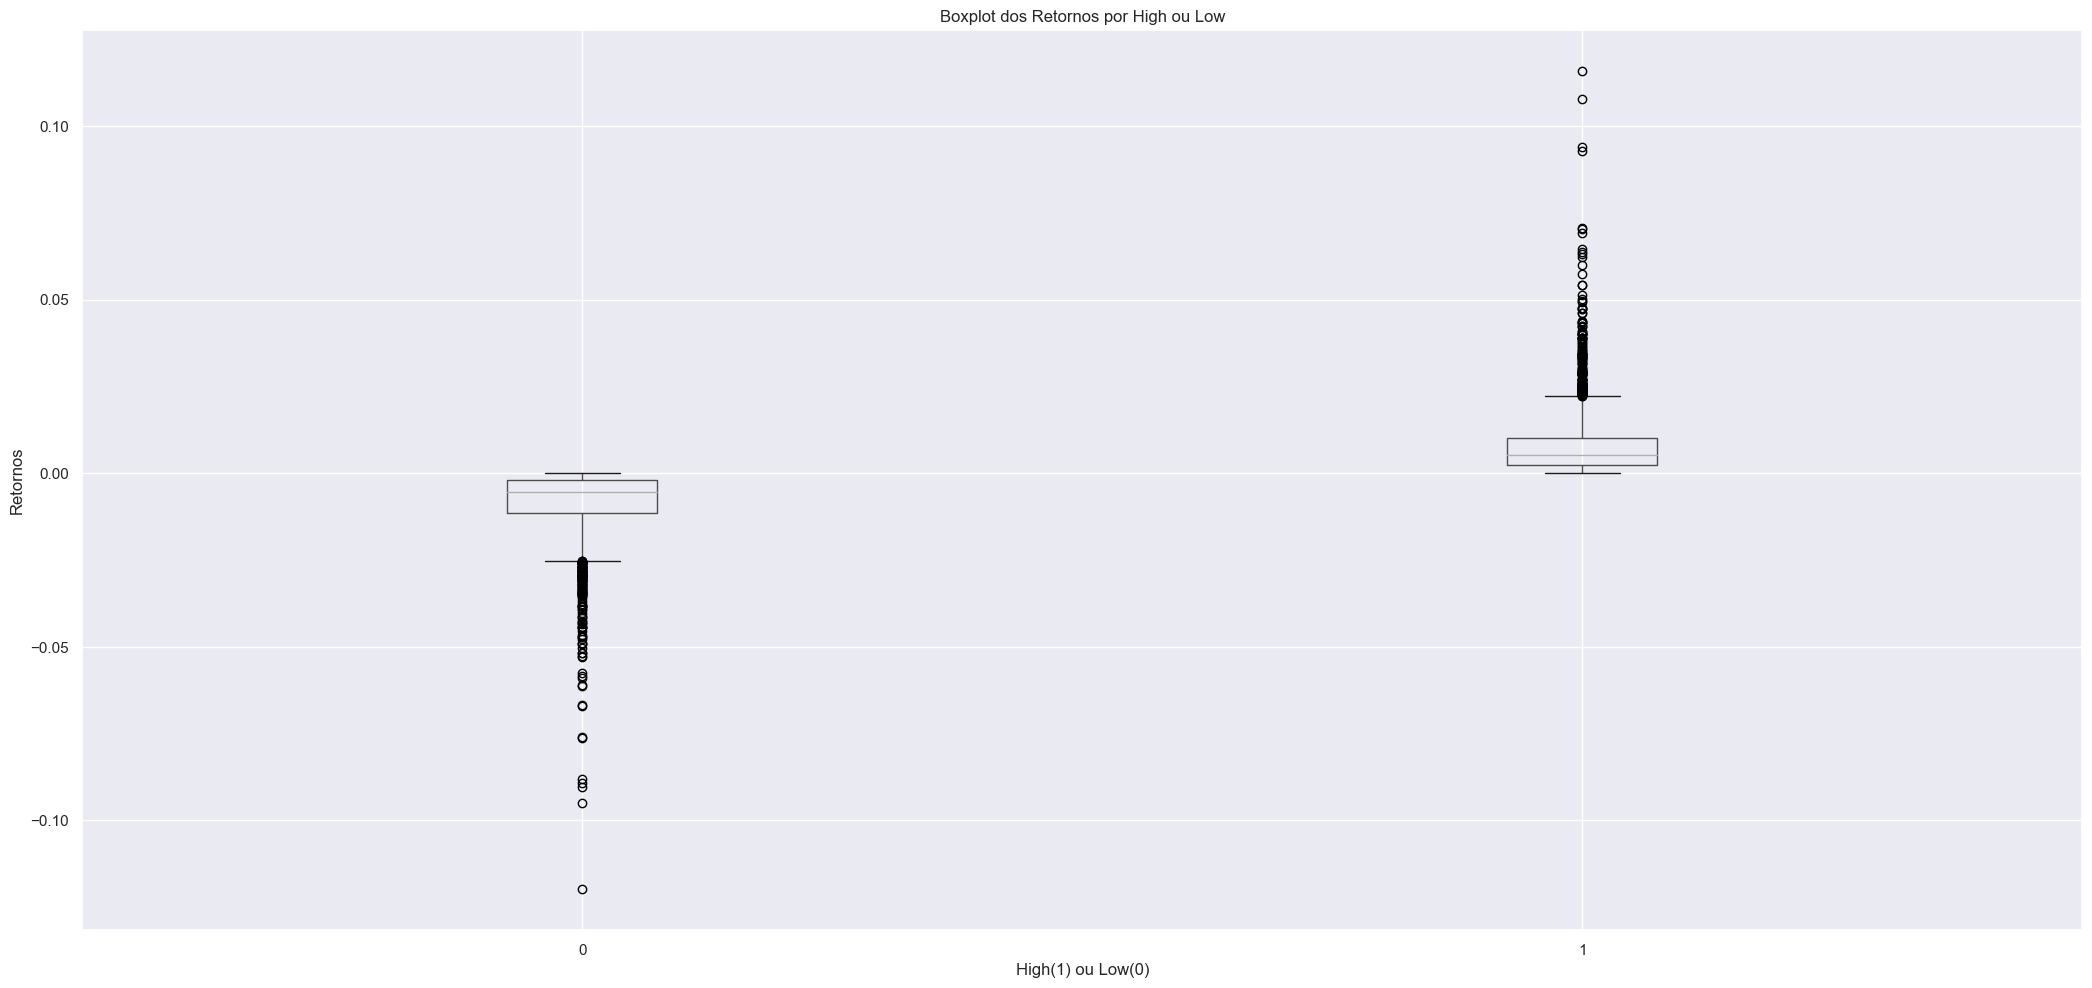

In [26]:
df4.boxplot( by='High_Low', column=['Retorno'], grid = True ) 
title = 'Boxplot dos Retornos por High ou Low'
plt.title( title )
plt.suptitle( '' ) # para eliminar o titulo padrao do boxplot do pandas
plt.ylabel( 'Retornos' )
plt.xlabel( 'High(1) ou Low(0)' )
plt.show();

# Feature Engineering

In [27]:
df5 = df4.copy()

In [28]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090


## Creating targets and features

In [29]:
# Adicionando um alvo

df5["Alvo1"] = df5["Retorno"].shift( -periodos )
df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0.0 , 1, 0 )

#df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0.0025 , 1, np.where( df5["Alvo1"] < -0.0025 , -1, 0 ) )

In [30]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin
Date,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN,-0.038345,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345,0.001922,1
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922,0.000956,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956,0.027090,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090,0.011190,1


In [31]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df5["std5"] = df5["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df5["std10"] = df5["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df5["std15"] = df5["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df5["prop"] = (df5["Close"]-df5["Open"])/(df5["High"]-df5["Low"])

# Direçao do dia atual
df5["dir_D"] = np.where(df5['Close'] > df5['Open'] , '1', '0')

# Direçao D-1
df5["dir_D-1"] = df5["dir_D"].shift(1)

# Direçao D-2
df5["dir_D-2"] = df5["dir_D"].shift(2)

# Direçao D-3
df5["dir_D-3"] = df5["dir_D"].shift(3)

# Media Movel de 15 dias std5
df5["mm_std5"] = df5["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std10"] = df5["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std15"] = df5["std15"].rolling(15).mean()

# RSL std5
df5["RSL_std5"] = df5["std5"]/df5["mm_std5"]

# RSL std10
df5["RSL_std10"] = df5["std10"]/df5["mm_std10"]

# RSL std15
df5["RSL_std15"] = df5["std15"]/df5["mm_std15"]

In [32]:
# Construção das novas variáveis indicados pelo Viola
df5['Variation'] = df5['Close'].diff()
df5 = df5[1:]
df5['Gain'] = np.where(df5['Variation'] > 0, df5['Variation'], 0) 
df5['Loss'] = np.where(df5['Variation'] < 0, df5['Variation'], 0)
n = 14
simple_avg_gain = df5['Gain'].rolling(n).mean()
simple_avg_loss = df5['Loss'].abs().rolling(n).mean()

# start off of simple average series
classic_avg_gain = simple_avg_gain.copy()
classic_avg_loss = simple_avg_loss.copy()

# iterate over the new series but only change values after the nth element
for i in range(n, len(classic_avg_gain)):
    classic_avg_gain[i] = (classic_avg_gain[i - 1] * (n - 1) + df5['Gain'].iloc[i]) / n
    classic_avg_loss[i] = (classic_avg_loss[i - 1] * (n - 1) + df5['Loss'].abs().iloc[i]) / n
    
df5['Simple RS'] = simple_avg_gain / simple_avg_loss
df5['Classic RS'] = classic_avg_gain / classic_avg_loss


df5['Simple RSI'] = 100 - (100 / (1 + df5['Simple RS']))
df5['Classic RSI'] = 100 - (100 / (1 + df5['Classic RS']))

In [33]:
df5.tail()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.006107,0.011127,0.010309,0.170128,1,0,1,1,0.011148,0.012396,0.012307,0.547805,0.897602,0.837688,6.709961,6.709961,0.000000,1.355512,1.585935,57.546389,61.329270
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,4778.729980,3124950000,4793.060059,0,-0.002990,NaN,0,0.006730,0.010281,0.010363,-0.461308,0,1,0,1,0.010845,0.012077,0.012185,0.620551,0.851298,0.850476,-14.330078,0.000000,-14.330078,1.465742,1.481133,59.444254,59.695830


In [34]:
# Filtrando os valores missing

df5_filtrado = df5.dropna( axis = 0 ).reset_index() 

#df5_filtrado= df5_filtrado.drop( ["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1 )

In [35]:
#df5_filtrado["RSL_std5"] = pd.qcut(df5_filtrado["RSL_std5"], 10, labels = False)
#df5_filtrado["RSL_std10"] = pd.qcut(df5_filtrado["RSL_std10"], 10, labels = False)
#df5_filtrado["RSL_std15"] = pd.qcut(df5_filtrado["RSL_std15"], 10, labels = False)

In [36]:
df5_filtrado.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
0,2000-02-14,1387.119995,1394.930054,1380.530029,1389.939941,1389.939941,927300000,1387.119995,1,0.002033,0.008713,1,0.015224,0.011925,0.013983,0.195829,1,0,1,0,0.013996,0.014166,0.014174,1.087800,0.841834,0.986538,2.819946,2.819946,0.000000,0.818156,0.714247,44.999228,41.665354
1,2000-02-15,1389.939941,1407.719971,1376.250000,1402.050049,1402.050049,1092100000,1389.939941,1,0.008713,-0.010256,0,0.014282,0.011745,0.014087,0.384815,1,1,0,1,0.014087,0.014162,0.014039,1.013838,0.829309,1.003464,12.110107,12.110107,0.000000,0.980487,0.821502,49.507361,45.100259
2,2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,1387.670044,1018800000,1402.050049,0,-0.010256,0.000425,1,0.012055,0.012144,0.014293,-0.758036,0,1,1,0,0.014060,0.014219,0.014149,0.857386,0.854073,1.010178,-14.380005,0.000000,-14.380005,0.903960,0.722418,47.477879,41.942100
3,2000-02-17,1387.670044,1399.880005,1380.069946,1388.260010,1388.260010,1034800000,1387.670044,1,0.000425,-0.030376,0,0.011669,0.011340,0.014266,0.029781,1,0,1,1,0.014002,0.014222,0.014254,0.833398,0.797395,1.000828,0.589966,0.589966,0.000000,1.374716,0.727747,57.889708,42.121172
4,2000-02-18,1388.260010,1388.589966,1345.319946,1346.089966,1346.089966,1042300000,1388.260010,0,-0.030376,0.004517,1,0.015285,0.014289,0.014676,-0.974579,0,1,0,1,0.014003,0.014339,0.014266,1.091592,0.996497,1.028733,-42.170044,0.000000,-42.170044,0.587146,0.516055,36.993822,34.039353


In [37]:
df5_filtrado.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
5500,2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.013513,0.011930,0.012006,0.886077,1,1,0,0,0.012790,0.012803,0.012224,1.056588,0.931805,0.982180,47.330078,47.330078,0.000000,1.408844,1.214334,58.486303,54.839686
5501,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809
5502,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473
5503,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656
5504,2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.006107,0.011127,0.010309,0.170128,1,0,1,1,0.011148,0.012396,0.012307,0.547805,0.897602,0.837688,6.709961,6.709961,0.000000,1.355512,1.585935,57.546389,61.329270


In [38]:
df_dollar_euro = pdr.get_data_yahoo( 'EURUSD=X', start=start, end=end )
df_dollar_euro.rename(columns={'Close': 'USDEUR'}, inplace=True)

df_dollar_real = pdr.get_data_yahoo( 'BRL=X', start=start, end=end )['Close'].reset_index()
df_dollar_real.rename(columns={'Close': 'USDBRL'}, inplace=True)

df_oil = pdr.get_data_yahoo( 'CL=F', start=start, end=end )['Close'].reset_index()
df_oil.rename(columns={'Close': 'Oil'}, inplace=True)

df_gold = pdr.get_data_yahoo( 'GC=F', start=start, end=end )['Close'].reset_index()
df_gold.rename(columns={'Close': 'Gold'}, inplace=True)

df_msft = pdr.get_data_yahoo( 'MSFT', start=start, end=end )
df_msft.rename(columns={'Close': 'MSFT'}, inplace=True)

df_aapl = pdr.get_data_yahoo( 'AAPL', start=start, end=end )['Close'].reset_index()
df_aapl.rename(columns={'Close': 'AAPL'}, inplace=True)

df_amzn = pdr.get_data_yahoo( 'AMZN', start=start, end=end )['Close'].reset_index()
df_amzn.rename(columns={'Close': 'AMZN'}, inplace=True)

df_meta = pdr.get_data_yahoo( 'META', start=start, end=end )['Close'].reset_index()
df_meta.rename(columns={'Close': 'META'}, inplace=True)

df_brk = pdr.get_data_yahoo( 'BRK-B', start=start, end=end )['Close'].reset_index()
df_brk.rename(columns={'Close': 'BRK'}, inplace=True)

df_jnj = pdr.get_data_yahoo( 'JNJ', start=start, end=end )['Close'].reset_index()
df_jnj.rename(columns={'Close': 'JNJ'}, inplace=True)

df_visa = pdr.get_data_yahoo( 'V', start=start, end=end )['Close'].reset_index()
df_visa.rename(columns={'Close': 'VISA'}, inplace=True)

df_disney = pdr.get_data_yahoo( 'DIS', start=start, end=end )['Close'].reset_index()
df_disney.rename(columns={'Close': 'DISNEY'}, inplace=True)

df_coke = pdr.get_data_yahoo( 'KO', start=start, end=end )['Close'].reset_index()
df_coke.rename(columns={'Close': 'COKE'}, inplace=True)

df_mcd = pdr.get_data_yahoo( 'MCD', start=start, end=end )['Close'].reset_index()
df_mcd.rename(columns={'Close': 'MCD'}, inplace=True)

df_nike = pdr.get_data_yahoo( 'NKE', start=start, end=end )['Close'].reset_index()
df_nike.rename(columns={'Close': 'NIKE'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [39]:
df_aux1 = df5_filtrado.merge(df_dollar_euro, on='Date').merge(df_dollar_real, on='Date').merge(df_oil, on='Date').merge(df_gold, on='Date')

In [40]:
# df_msft, df_aapl, df_amzn, df_meta, df_brk, df_jnj, df_visa, df_disney, df_coke, df_mcd, df_nike
df_aux1 = df_aux1.merge(df_msft,  on='Date').merge(df_aapl,  on='Date').merge(df_amzn,  on='Date').merge(df_meta,  on='Date').merge(df_brk,  on='Date').merge(df_jnj,  on='Date').merge(df_visa,  on='Date').merge(df_disney,  on='Date').merge(df_coke,  on='Date').merge(df_mcd,  on='Date').merge(df_nike,  on='Date')

In [41]:
df_aux1['USDEUR_Retorno'] = df_aux1['USDEUR'].pct_change( periodos )
df_aux1["USDEUR_Alvo1"] = df_aux1["USDEUR_Retorno"].shift( -periodos )
#df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Alvo1"] > 0 , 1, 0 )
df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Retorno"] > 0 , 1, 0 )

df_aux1['USDBRL_Retorno'] = df_aux1['USDBRL'].pct_change( periodos )
df_aux1["USDBRL_Alvo1"] = df_aux1["USDBRL_Retorno"].shift( -periodos )
#df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Alvo1"] > 0 , 1, 0 )
df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Retorno"] > 0 , 1, 0 )

df_aux1['Oil_Retorno'] = df_aux1['Oil'].pct_change( periodos )
df_aux1["Oil_Alvo1"] = df_aux1["Oil_Retorno"].shift( -periodos )
#df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Alvo1"] > 0 , 1, 0 )
df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Retorno"] > 0 , 1, 0 )

df_aux1['Gold_Retorno'] = df_aux1['Gold'].pct_change( periodos )
df_aux1["Gold_Alvo1"] = df_aux1["Gold_Retorno"].shift( -periodos )
#df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Alvo1"] > 0 , 1, 0 )
df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Retorno"] > 0 , 1, 0 )

df_aux1['msft_Retorno'] = df_aux1['MSFT'].pct_change( periodos )
df_aux1["msft_Alvo1"] = df_aux1["msft_Retorno"].shift( -periodos )
#df_aux1["msft_Bin"] = np.where( df_aux1["msft_Alvo1"] > 0 , 1, 0 )
df_aux1["msft_Bin"] = np.where( df_aux1["msft_Retorno"] > 0 , 1, 0 )

df_aux1['aapl_Retorno'] = df_aux1['AAPL'].pct_change( periodos )
df_aux1["aapl_Alvo1"] = df_aux1["aapl_Retorno"].shift( -periodos )
#df_aux1["aapl_Bin"] = np.where( df_aux1["aapl_Alvo1"] > 0 , 1, 0 )
df_aux1["aapl_Bin"] = np.where( df_aux1["aapl_Retorno"] > 0 , 1, 0 )

df_aux1['amzn_Retorno'] = df_aux1['AMZN'].pct_change( periodos )
df_aux1["amzn_Alvo1"] = df_aux1["amzn_Retorno"].shift( -periodos )
#df_aux1["amzn_Bin"] = np.where( df_aux1["amzn_Alvo1"] > 0 , 1, 0 )
df_aux1["amzn_Bin"] = np.where( df_aux1["amzn_Retorno"] > 0 , 1, 0 )

df_aux1['meta_Retorno'] = df_aux1['META'].pct_change( periodos )
df_aux1["meta_Alvo1"] = df_aux1["meta_Retorno"].shift( -periodos )
#df_aux1["meta_Bin"] = np.where( df_aux1["meta_Alvo1"] > 0 , 1, 0 )
df_aux1["meta_Bin"] = np.where( df_aux1["meta_Retorno"] > 0 , 1, 0 )

df_aux1['brk_Retorno'] = df_aux1['BRK'].pct_change( periodos )
df_aux1["brk_Alvo1"] = df_aux1["brk_Retorno"].shift( -periodos )
#df_aux1["brk_Bin"] = np.where( df_aux1["brk_Alvo1"] > 0 , 1, 0 )
df_aux1["brk_Bin"] = np.where( df_aux1["brk_Retorno"] > 0 , 1, 0 )

df_aux1['jnj_Retorno'] = df_aux1['JNJ'].pct_change( periodos )
df_aux1["jnj_Alvo1"] = df_aux1["jnj_Retorno"].shift( -periodos )
#df_aux1["jnj_Bin"] = np.where( df_aux1["jnj_Alvo1"] > 0 , 1, 0 )
df_aux1["jnj_Bin"] = np.where( df_aux1["jnj_Retorno"] > 0 , 1, 0 )

df_aux1['visa_Retorno'] = df_aux1['VISA'].pct_change( periodos )
df_aux1["visa_Alvo1"] = df_aux1["visa_Retorno"].shift( -periodos )
#df_aux1["visa_Bin"] = np.where( df_aux1["visa_Alvo1"] > 0 , 1, 0 )
df_aux1["visa_Bin"] = np.where( df_aux1["visa_Retorno"] > 0 , 1, 0 )

df_aux1['disney_Retorno'] = df_aux1['DISNEY'].pct_change( periodos )
df_aux1["disney_Alvo1"] = df_aux1["disney_Retorno"].shift( -periodos )
#df_aux1["disney_Bin"] = np.where( df_aux1["disney_Alvo1"] > 0 , 1, 0 )
df_aux1["disney_Bin"] = np.where( df_aux1["disney_Retorno"] > 0 , 1, 0 )

df_aux1['coke_Retorno'] = df_aux1['COKE'].pct_change( periodos )
df_aux1["coke_Alvo1"] = df_aux1["coke_Retorno"].shift( -periodos )
#df_aux1["coke_Bin"] = np.where( df_aux1["coke_Alvo1"] > 0 , 1, 0 )
df_aux1["coke_Bin"] = np.where( df_aux1["coke_Retorno"] > 0 , 1, 0 )

df_aux1['mcd_Retorno'] = df_aux1['MCD'].pct_change( periodos )
df_aux1["mcd_Alvo1"] = df_aux1["mcd_Retorno"].shift( -periodos )
#df_aux1["mcd_Bin"] = np.where( df_aux1["mcd_Alvo1"] > 0 , 1, 0 )
df_aux1["mcd_Bin"] = np.where( df_aux1["mcd_Retorno"] > 0 , 1, 0 )

df_aux1['nike_Retorno'] = df_aux1['NIKE'].pct_change( periodos )
df_aux1["nike_Alvo1"] = df_aux1["nike_Retorno"].shift( -periodos )
#df_aux1["nike_Bin"] = np.where( df_aux1["nike_Alvo1"] > 0 , 1, 0 )
df_aux1["nike_Bin"] = np.where( df_aux1["nike_Retorno"] > 0 , 1, 0 )

In [42]:
df_aux1.head(10)

,Date,Open_x,High_x,Low_x,Close,Adj Close_x,Volume_x,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI,Open_y,High_y,Low_y,USDEUR,Adj Close_y,Volume_y,USDBRL,Oil,Gold,Open,High,Low,MSFT,Adj Close,Volume,AAPL,AMZN,META,BRK,JNJ,VISA,DISNEY,COKE,MCD,NIKE,USDEUR_Retorno,USDEUR_Alvo1,USDEUR_Bin,USDBRL_Retorno,USDBRL_Alvo1,USDBRL_Bin,Oil_Retorno,Oil_Alvo1,Oil_Bin,Gold_Retorno,Gold_Alvo1,Gold_Bin,msft_Retorno,msft_Alvo1,msft_Bin,aapl_Retorno,aapl_Alvo1,aapl_Bin,amzn_Retorno,amzn_Alvo1,amzn_Bin,meta_Retorno,meta_Alvo1,meta_Bin,brk_Retorno,brk_Alvo1,brk_Bin,jnj_Retorno,jnj_Alvo1,jnj_Bin,visa_Retorno,visa_Alvo1,visa_Bin,disney_Retorno,disney_Alvo1,disney_Bin,coke_Retorno,coke_Alvo1,coke_Bin,mcd_Retorno,mcd_Alvo1,mcd_Bin,nike_Retorno,nike_Alvo1,nike_Bin
0,2012-05-18,1305.050049,1312.239990,1291.979980,1295.219971,1295.219971,4512470000,1304.859985,0,-0.007388,0.016036,1,0.004332,0.005093,0.005899,-0.485196,0,0,0,0,0.005771,0.006748,0.007579,0.750602,0.754820,0.778293,-9.640015,0.000000,-9.640015,0.103065,0.302462,9.343522,23.222325,1.269841,1.273983,1.264558,1.269841,1.269841,0,2.0077,91.480003,1591.599976,29.790001,29.809999,29.170000,29.270000,23.721565,56205300,18.942142,10.6925,38.230000,78.910004,63.349998,28.160000,43.810001,37.025002,89.849998,26.360001,NaN,0.005876,0,NaN,0.007123,0,NaN,0.011915,0,NaN,-0.002011,0,NaN,0.016399,0,NaN,0.058260,0,NaN,0.019921,0,NaN,-0.109861,0,NaN,0.011279,0,NaN,0.001894,0,NaN,0.031783,0,NaN,0.013239,0,NaN,0.006212,0,NaN,0.015804,0,NaN,0.016976,0
1,2012-05-21,1295.729980,1316.390015,1295.729980,1315.989990,1315.989990,3786750000,1295.219971,1,0.016036,0.000486,1,0.011575,0.008427,0.008082,0.980638,1,0,0,0,0.006116,0.006772,0.007472,1.892396,1.244403,1.081604,20.770020,20.770020,0.000000,0.215390,0.527330,17.721904,34.526285,1.277302,1.281230,1.273075,1.277302,1.277302,0,2.0220,92.570000,1588.400024,29.100000,29.790001,29.059999,29.750000,24.110573,38787900,20.045713,10.9055,34.029999,79.800003,63.470001,29.055000,44.389999,37.255001,91.269997,26.807501,0.005876,0.002946,1,0.007123,0.005094,1,0.011915,-0.009830,1,-0.002011,-0.007618,0,0.016399,0.000336,1,0.058260,-0.007679,1,0.019921,-0.012746,1,-0.109861,-0.089039,0,0.011279,-0.001880,1,0.001894,0.000788,1,0.031783,0.018671,1,0.013239,0.000000,1,0.006212,-0.004295,1,0.015804,0.000767,1,0.016976,0.011377,1
2,2012-05-22,1316.089966,1328.489990,1310.040039,1316.630005,1316.630005,4123680000,1315.989990,1,0.000486,0.001694,1,0.011582,0.008540,0.007745,0.029270,1,1,0,0,0.006462,0.006891,0.007430,1.792309,1.239203,1.042276,0.640015,0.640015,0.000000,0.227969,0.534793,18.564735,34.844620,1.281394,1.281394,1.274048,1.281066,1.281066,0,2.0323,91.660004,1576.300049,29.690001,29.879999,29.500000,29.760000,24.118685,39504900,19.891787,10.7665,31.000000,79.650002,63.520000,29.597500,44.389999,37.095001,91.339996,27.112499,0.002946,-0.011398,1,0.005094,0.027063,1,-0.009830,-0.019201,0,-0.007618,-0.017890,0,0.000336,-0.021841,1,-0.007679,0.024400,0,-0.012746,0.009056,0,-0.089039,0.032258,0,-0.001880,0.001255,0,0.000788,-0.003936,1,0.018671,0.006588,1,0.000000,-0.004055,0,-0.004295,0.004852,0,0.000767,0.001533,1,0.011377,-0.008575,1
3,2012-05-23,1316.020020,1320.709961,1296.530029,1318.859985,1318.859985,4108330000,1316.630005,1,0.001694,0.001380,1,0.011595,0.008600,0.007890,0.117451,1,1,1,0,0.006919,0.007023,0.007401,1.675769,1.224520,1.066043,2.229980,2.229980,0.000000,0.274641,0.562793,21.546549,36.011996,1.266464,1.268392,1.257008,1.266464,1.266464,0,2.0873,89.900002,1548.099976,29.350000,29.400000,28.639999,29.110001,23.591898,65171000,20.377144,10.8640,32.000000,79.750000,63.270000,29.792500,44.209999,37.275002,91.480003,26.879999,-0.011398,-0.008165,0,0.027063,-0.028841,1,-0.019201,0.008454,0,-0.017890,0.005943,0,-0.021841,-0.001374,0,0.024400,-0.009184,1,0.009056,-0.009389,1,0.032258,0.032187,1,0.0012

In [43]:
# df_msft, df_aapl, df_amzn, df_meta, df_brk, df_jnj, df_visa, df_disney, df_coke, df_mcd, df_nike

In [44]:
df_aux1.tail()

,Date,Open_x,High_x,Low_x,Close,Adj Close_x,Volume_x,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI,Open_y,High_y,Low_y,USDEUR,Adj Close_y,Volume_y,USDBRL,Oil,Gold,Open,High,Low,MSFT,Adj Close,Volume,AAPL,AMZN,META,BRK,JNJ,VISA,DISNEY,COKE,MCD,NIKE,USDEUR_Retorno,USDEUR_Alvo1,USDEUR_Bin,USDBRL_Retorno,USDBRL_Alvo1,USDBRL_Bin,Oil_Retorno,Oil_Alvo1,Oil_Bin,Gold_Retorno,Gold_Alvo1,Gold_Bin,msft_Retorno,msft_Alvo1,msft_Bin,aapl_Retorno,aapl_Alvo1,aapl_Bin,amzn_Retorno,amzn_Alvo1,amzn_Bin,meta_Retorno,meta_Alvo1,meta_Bin,brk_Retorno,brk_Alvo1,brk_Bin,jnj_Retorno,jnj_Alvo1,jnj_Bin,visa_Retorno,visa_Alvo1,visa_Bin,disney_Retorno,disney_Alvo1,disney_Bin,coke_Retorno,coke_Alvo1,coke_Bin,mcd_Retorno,mcd_Alvo1,mcd_Bin,nike_Retorno,nike_Alvo1,nike_Bin
2406,2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.013513,0.011930,0.012006,0.886077,1,1,0,0,0.012790,0.012803,0.012224,1.056588,0.931805,0.982180,47.330078,47.330078,0.000000,1.408844,1.214334,58.486303,54.839686,1.129050,1.134200,1.126532,1.128757,1.128757,0,5.7440,72.760002,1801.599976,328.299988,333.609985,325.750000,333.200012,329.282104,24831500,175.639999,171.037003,330.450012,294.410004,167.929993,217.960007,151.880005,58.180000,264.940002,165.440002,0.000892,0.003659,1,0.000470,-0.015843,1,0.023060,0.014156,1,0.007663,0.005329,1,0.018057,0.004472,1,0.015319,0.003644,1,0.003638,0.000184,1,-0.011221,0.014495,0,0.003990,0.000272,1,0.004306,0.001906,1,0.011979,-0.006148,1,0.005495,0.011522,1,0.007097,0.000688,1,0.002080,0.003812,1,-0.007142,0.001390,0
2407,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809,1.133016,1.134559,1.129152,1.132888,1.132888,0,5.6530,73.790001,1811.199951,332.750000,336.390015,332.730011,334.690002,330.754578,19617800,176.279999,171.068497,335.239990,294.489990,168.250000,216.619995,153.630005,58.220001,265.950012,165.669998,0.003659,-0.000408,1,-0.015843,0.003202,0,0.014156,0.024122,1,0.005329,-0.001712,1,0.004472,0.023186,1,0.003644,0.022975,1,0.000184,-0.008178,1,0.014495,0.032633,1,0.000272,0.007403,1,0.001906,0.008440,1,-0.006148,0.004663,0,0.011522,-0.005403,1,0.000688,0.007386,1,0.003812,0.008611,1,0.001390,0.011529,1
2408,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473,1.132387,1.133500,1.130416,1.132426,1.132426,0,5.6711,75.570000,1808.099976,335.459991,342.480011,335.429993,342.450012,338.423340,19947000,180.330002,169.669495,346.179993,296.670013,169.669998,217.630005,152.800003,58.650002,268.239990,167.580002,-0.000408,0.000510,0,0.003202,-0.008288,1,0.024122,0.005425,1,-0.001712,0.001161,0,0.023186,-0.003504,1,0.022975,-0.005767,1,-0.008178,0.005844,0,0.032633,0.000116,1,0.007403,0.005461,1,0.008440,0.004008,1,0.004663,0.001930,1,-0.005403,0.015707,0,0.007386,0.003922,1,0.008611,-0.001342,1,0.011529,-0.006922,1
2409,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656,1.132978,1.133600,1.129038,1.133003,1.133003,0,5.6241,75.980003,1810.199951,343.149994,343.809998,340.320007,341.250000,337.237396,15661500,179.289993,170.660995,346.220001,298.290009,170.350006,218.050003,155.199997,58.880001,267.880005,166.419998,0.000510,-0.001346,1,-0.

In [45]:
df5.dropna( axis = 0, inplace=True )

# Machine Learning Modelling

In [871]:
df6 = df_aux1.copy()
#df6 = df5_filtrado.copy()

## Split into training and test dataset

In [872]:
print('Menor data: ', df6['Date'].min())
print('Maior data: ', df6['Date'].max())

Menor data:  2012-05-18 00:00:00
Maior data:  2021-12-29 00:00:00


In [873]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2000 à 2017
#start_train = "2000-01-01" #"2000-02-14"
#end_train = "2017-12-31"
start_train = "2019-01-01"
end_train = "2019-10-31"


# Vamos testar o modelo de 2018 à 2019
#start_test = "2018-01-01"
#end_test = "2019-12-31"
start_test = "2019-11-01"
end_test = "2019-12-31"

df6_train1 = df6[(df6['Date'] >= start_train) & (df6['Date'] <= end_train)]

df6_test1 = df6[(df6['Date'] >= start_test) & (df6['Date'] <= end_test)]

In [874]:
df6.columns

Index(['Date', 'Open_x', 'High_x', 'Low_x', 'Close', 'Adj Close_x', 'Volume_x',
       'Lag_P1', 'High_Low', 'Retorno',
       ...
       'disney_Bin', 'coke_Retorno', 'coke_Alvo1', 'coke_Bin', 'mcd_Retorno',
       'mcd_Alvo1', 'mcd_Bin', 'nike_Retorno', 'nike_Alvo1', 'nike_Bin'],
      dtype='object', length=103)

In [875]:
# 'std5','std10','std15','mm_std5','mm_std10','mm_std15'
# 'prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15'
# 'USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin'
# 'msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin'
# 'Simple RSI', 'Classic RSI'

In [876]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df6_train1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15','USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin','msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin']]
y_train1 = df6_train1['Alvo1_Bin']
#y_train1 = df6_train1['Alvo1']


x_test1 = df6_test1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15','USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin','msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin']]
y_test1 = df6_test1['Alvo1_Bin']
#y_test1 = df6_test1['Alvo1']

In [877]:
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=42)
#x_train1, y_train1 = sm.fit_resample(x_train1, y_train1)

# Logistic Regression

In [878]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression( random_state=42 ).fit( x_train1, y_train1)
lr_pred = lr_model.predict( x_test1 )

In [879]:
# Teste

print(confusion_matrix( y_test1, lr_pred ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, lr_pred ) )

[[ 5  8]
 [11 17]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.31      0.38      0.34        13
           1       0.68      0.61      0.64        28

    accuracy                           0.54        41
   macro avg       0.50      0.50      0.49        41
weighted avg       0.56      0.54      0.55        41



In [880]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve( y_test1, lr_pred )
auc( fpr, tpr )

0.4958791208791209

C:\Users\lucas\anaconda3\envs\py_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


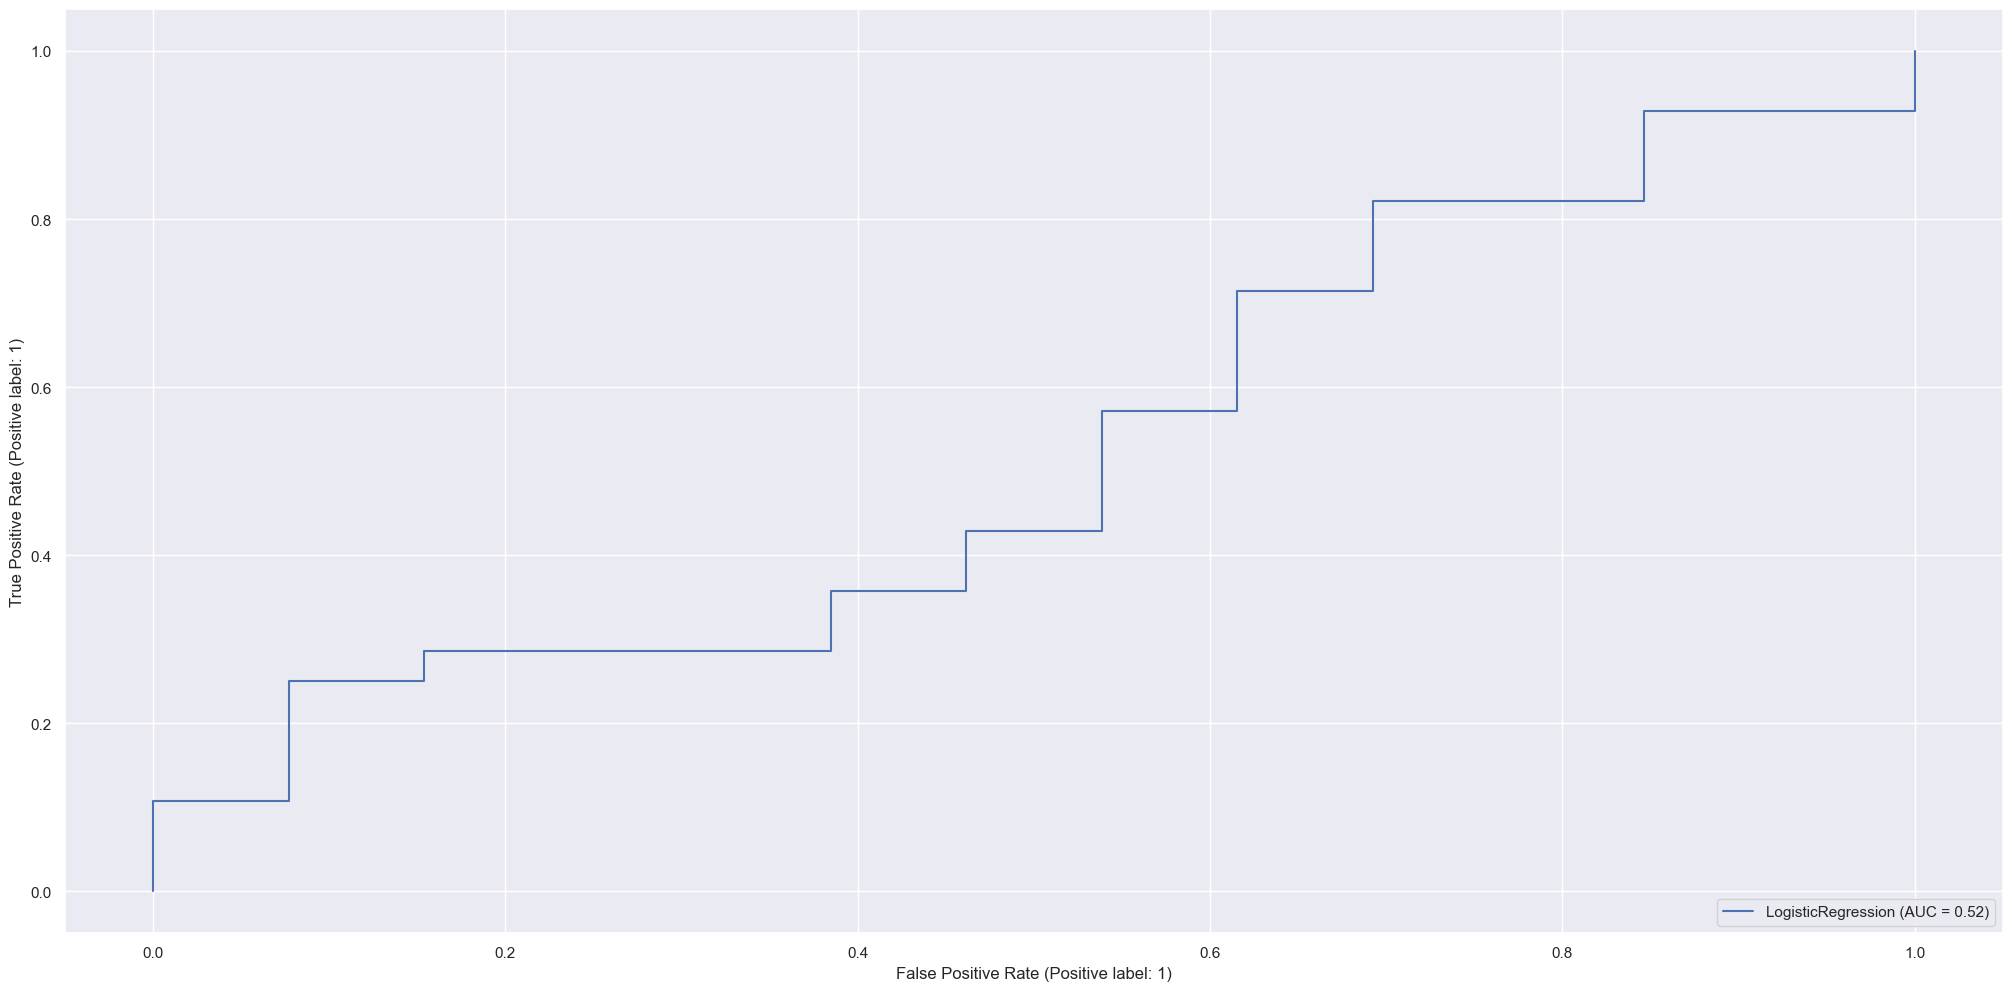

In [881]:
plot_roc_curve(lr_model, x_test1, y_test1)

# Neural Networks

## Feature Scaling

In [882]:
x_train1.head()

,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,USDEUR_Bin,USDBRL_Bin,Oil_Bin,Gold_Bin,msft_Bin,aapl_Bin,amzn_Bin,meta_Bin,brk_Bin,jnj_Bin,visa_Bin,disney_Bin,coke_Bin,mcd_Bin,nike_Bin
1657,0.635718,1,1,0,1,1.241050,1.332609,1.180615,1,1,1,1,0,1,1,1,0,0,1,0,0,0,0
1658,-0.895284,0,1,1,0,0.825904,1.369015,1.206746,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1659,0.903826,1,0,1,1,1.231332,1.461083,1.312694,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1
1660,0.338459,1,1,0,1,1.178463,1.364275,1.278748,1,0,1,1,1,0,1,1,1,0,1,1,0,1,1
1661,0.195282,1,1,1,0,1.132601,1.243205,1.226925,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1


In [883]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sc = MinMaxScaler( feature_range = (0, 1) )
#sc = StandardScaler()
x_train1 = sc.fit_transform( x_train1 )

In [884]:
#x_train1

In [885]:
#x_test1 = np.asarray( x_test1 ).astype( np.float32 )
x_test1 = sc.transform( x_test1 )
x_test1 = np.reshape( x_test1, ( x_test1.shape[0], x_test1.shape[1], 1 ) )

## Reshaping

In [886]:
#x_train1.head()

In [887]:
x_train1 = np.asarray( x_train1 ).astype( np.float32 )
x_train1 = np.reshape( x_train1, ( x_train1.shape[0], x_train1.shape[1], 1 ) )

## Initialising the RNN

In [888]:
clf = Sequential()

## Adding the first layer and dropout regularisation

In [889]:
clf.add( LSTM( units = 100, return_sequences = True, input_shape = ( x_train1.shape[1], 1 ), dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a second layer and dropout regularisation

In [890]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a third layer and dropout regularisation

In [891]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a fourth layer and dropout regularisation

In [892]:
clf.add( LSTM( units = 100, activation='relu', dropout=0.2, recurrent_dropout=0.2) )
#clf.add( Dropout( 0.2 ) )

## Adding the output layer and dropout regularisation

In [893]:
clf.add( Dense( units = 1, activation='sigmoid' ) )

## Compiling the RNN

In [894]:
clf.compile( optimizer = 'Nadam', loss = 'binary_crossentropy', metrics=['accuracy'] )
#clf.compile( optimizer = 'adam', loss = 'mean_squared_error')

## Fitting the RNN

In [895]:
clf.fit( x_train1, y_train1, epochs = 1000, batch_size = 100, shuffle=False, validation_data=(x_test1, y_test1) )

Epoch 1/1000
3/3 [==============================] - 41s 3s/step - loss: 0.6925 - accuracy: 0.5952 - val_loss: 0.6824 - val_accuracy: 0.6829
Epoch 2/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6881 - accuracy: 0.5810 - val_loss: 0.6538 - val_accuracy: 0.6829
Epoch 3/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6823 - accuracy: 0.5810 - val_loss: 0.6365 - val_accuracy: 0.6829
Epoch 4/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6841 - accuracy: 0.5810 - val_loss: 0.6418 - val_accuracy: 0.6829
Epoch 5/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6823 - accuracy: 0.5810 - val_loss: 0.6356 - val_accuracy: 0.6829
Epoch 6/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6822 - accuracy: 0.5810 - val_loss: 0.6371 - val_accuracy: 0.6829
Epoch 7/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6813 - accuracy: 0.5810 - val_loss: 0.6369 - val_accuracy: 0.6829
Epoch 8/1000
3/3 [========

3/3 [==============================] - 5s 2s/step - loss: 0.6922 - accuracy: 0.5810 - val_loss: 0.6412 - val_accuracy: 0.6829
Epoch 60/1000
3/3 [==============================] - 5s 2s/step - loss: 0.6925 - accuracy: 0.5810 - val_loss: 0.6424 - val_accuracy: 0.6829
Epoch 61/1000
3/3 [==============================] - 5s 2s/step - loss: 0.6802 - accuracy: 0.5810 - val_loss: 0.6448 - val_accuracy: 0.6829
Epoch 62/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6835 - accuracy: 0.5810 - val_loss: 0.6474 - val_accuracy: 0.6829
Epoch 63/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6897 - accuracy: 0.5810 - val_loss: 0.6469 - val_accuracy: 0.6829
Epoch 64/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6857 - accuracy: 0.5810 - val_loss: 0.6465 - val_accuracy: 0.6829
Epoch 65/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6890 - accuracy: 0.5810 - val_loss: 0.6475 - val_accuracy: 0.6829
Epoch 66/1000
3/3 [===============

3/3 [==============================] - 6s 2s/step - loss: 0.6994 - accuracy: 0.5905 - val_loss: 0.6543 - val_accuracy: 0.6829
Epoch 118/1000
3/3 [==============================] - 5s 2s/step - loss: 0.6949 - accuracy: 0.5619 - val_loss: 0.6549 - val_accuracy: 0.6829
Epoch 119/1000
3/3 [==============================] - 5s 2s/step - loss: 0.6853 - accuracy: 0.6095 - val_loss: 0.6509 - val_accuracy: 0.6829
Epoch 120/1000
3/3 [==============================] - 5s 2s/step - loss: 0.7025 - accuracy: 0.5810 - val_loss: 0.6405 - val_accuracy: 0.6829
Epoch 121/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6920 - accuracy: 0.5762 - val_loss: 0.6467 - val_accuracy: 0.6829
Epoch 122/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6878 - accuracy: 0.5810 - val_loss: 0.6515 - val_accuracy: 0.6829
Epoch 123/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6779 - accuracy: 0.5762 - val_loss: 0.6481 - val_accuracy: 0.6829
Epoch 124/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 0.7073 - accuracy: 0.5810 - val_loss: 0.6160 - val_accuracy: 0.6585
Epoch 176/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6885 - accuracy: 0.5857 - val_loss: 0.6162 - val_accuracy: 0.6829
Epoch 177/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6905 - accuracy: 0.6143 - val_loss: 0.6257 - val_accuracy: 0.6829
Epoch 178/1000
3/3 [==============================] - 5s 2s/step - loss: 0.6739 - accuracy: 0.6238 - val_loss: 0.6298 - val_accuracy: 0.6585
Epoch 179/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6786 - accuracy: 0.6286 - val_loss: 0.6243 - val_accuracy: 0.6585
Epoch 180/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6797 - accuracy: 0.6238 - val_loss: 0.6301 - val_accuracy: 0.6585
Epoch 181/1000
3/3 [==============================] - 6s 2s/step - loss: 0.7015 - accuracy: 0.6095 - val_loss: 0.6351 - val_accuracy: 0.6585
Epoch 182/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 0.6605 - accuracy: 0.6143 - val_loss: 0.6356 - val_accuracy: 0.6341
Epoch 234/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6617 - accuracy: 0.6190 - val_loss: 0.6339 - val_accuracy: 0.6341
Epoch 235/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6821 - accuracy: 0.6095 - val_loss: 0.6304 - val_accuracy: 0.6341
Epoch 236/1000
3/3 [==============================] - 6s 2s/step - loss: 0.7047 - accuracy: 0.5810 - val_loss: 0.6215 - val_accuracy: 0.7073
Epoch 237/1000
3/3 [==============================] - 6s 2s/step - loss: 0.7166 - accuracy: 0.5667 - val_loss: 0.6237 - val_accuracy: 0.7073
Epoch 238/1000
3/3 [==============================] - 5s 2s/step - loss: 0.6568 - accuracy: 0.6286 - val_loss: 0.6323 - val_accuracy: 0.6585
Epoch 239/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6777 - accuracy: 0.6048 - val_loss: 0.6431 - val_accuracy: 0.6341
Epoch 240/1000
3/3 [========

3/3 [==============================] - 5s 1s/step - loss: 0.6151 - accuracy: 0.6762 - val_loss: 0.6729 - val_accuracy: 0.6585
Epoch 292/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6301 - accuracy: 0.6048 - val_loss: 0.6725 - val_accuracy: 0.6829
Epoch 293/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6495 - accuracy: 0.6286 - val_loss: 0.6795 - val_accuracy: 0.6585
Epoch 294/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6516 - accuracy: 0.6667 - val_loss: 0.6824 - val_accuracy: 0.6585
Epoch 295/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6785 - accuracy: 0.6333 - val_loss: 0.6739 - val_accuracy: 0.6341
Epoch 296/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6482 - accuracy: 0.6333 - val_loss: 0.6508 - val_accuracy: 0.6341
Epoch 297/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6757 - accuracy: 0.6095 - val_loss: 0.6227 - val_accuracy: 0.6585
Epoch 298/1000
3/3 [========

3/3 [==============================] - 5s 1s/step - loss: 0.6426 - accuracy: 0.6476 - val_loss: 0.6814 - val_accuracy: 0.6098
Epoch 350/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6522 - accuracy: 0.6571 - val_loss: 0.6824 - val_accuracy: 0.6098
Epoch 351/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6402 - accuracy: 0.6524 - val_loss: 0.6752 - val_accuracy: 0.5854
Epoch 352/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6159 - accuracy: 0.6571 - val_loss: 0.6690 - val_accuracy: 0.6098
Epoch 353/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6402 - accuracy: 0.6190 - val_loss: 0.6352 - val_accuracy: 0.6829
Epoch 354/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6235 - accuracy: 0.6714 - val_loss: 0.6377 - val_accuracy: 0.6585
Epoch 355/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6598 - accuracy: 0.6476 - val_loss: 0.6359 - val_accuracy: 0.6585
Epoch 356/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 0.5965 - accuracy: 0.6667 - val_loss: 0.6834 - val_accuracy: 0.6585
Epoch 408/1000
3/3 [==============================] - 6s 2s/step - loss: 0.5982 - accuracy: 0.6762 - val_loss: 0.6832 - val_accuracy: 0.6098
Epoch 409/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6152 - accuracy: 0.6857 - val_loss: 0.6983 - val_accuracy: 0.6098
Epoch 410/1000
3/3 [==============================] - 6s 2s/step - loss: 0.6684 - accuracy: 0.6286 - val_loss: 0.6715 - val_accuracy: 0.6098
Epoch 411/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6153 - accuracy: 0.6571 - val_loss: 0.6929 - val_accuracy: 0.6585
Epoch 412/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6013 - accuracy: 0.6476 - val_loss: 0.7396 - val_accuracy: 0.6098
Epoch 413/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6025 - accuracy: 0.6571 - val_loss: 0.7357 - val_accuracy: 0.6341
Epoch 414/1000
3/3 [========

3/3 [==============================] - 5s 1s/step - loss: 0.6080 - accuracy: 0.6429 - val_loss: 0.6903 - val_accuracy: 0.6341
Epoch 466/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6161 - accuracy: 0.6381 - val_loss: 0.6649 - val_accuracy: 0.6098
Epoch 467/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5976 - accuracy: 0.6857 - val_loss: 0.6522 - val_accuracy: 0.6098
Epoch 468/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6067 - accuracy: 0.6714 - val_loss: 0.7004 - val_accuracy: 0.5854
Epoch 469/1000
3/3 [==============================] - 5s 2s/step - loss: 0.5713 - accuracy: 0.6714 - val_loss: 0.6769 - val_accuracy: 0.6341
Epoch 470/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5997 - accuracy: 0.6619 - val_loss: 0.6971 - val_accuracy: 0.6341
Epoch 471/1000
3/3 [==============================] - 5s 2s/step - loss: 0.5881 - accuracy: 0.6810 - val_loss: 0.7500 - val_accuracy: 0.6098
Epoch 472/1000
3/3 [========

3/3 [==============================] - 5s 1s/step - loss: 0.5567 - accuracy: 0.7333 - val_loss: 0.8333 - val_accuracy: 0.5366
Epoch 524/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6324 - accuracy: 0.6476 - val_loss: 0.7240 - val_accuracy: 0.5610
Epoch 525/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5328 - accuracy: 0.7286 - val_loss: 0.6940 - val_accuracy: 0.5854
Epoch 526/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5628 - accuracy: 0.7000 - val_loss: 0.7613 - val_accuracy: 0.5610
Epoch 527/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5480 - accuracy: 0.7143 - val_loss: 0.8551 - val_accuracy: 0.5366
Epoch 528/1000
3/3 [==============================] - 5s 1s/step - loss: 0.6032 - accuracy: 0.6857 - val_loss: 0.8911 - val_accuracy: 0.4634
Epoch 529/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5997 - accuracy: 0.6714 - val_loss: 0.7924 - val_accuracy: 0.5854
Epoch 530/1000
3/3 [========

3/3 [==============================] - 5s 1s/step - loss: 0.5694 - accuracy: 0.7143 - val_loss: 0.6634 - val_accuracy: 0.6341
Epoch 582/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5555 - accuracy: 0.7048 - val_loss: 0.6449 - val_accuracy: 0.6585
Epoch 583/1000
3/3 [==============================] - 5s 1s/step - loss: 0.4974 - accuracy: 0.7524 - val_loss: 0.7073 - val_accuracy: 0.6341
Epoch 584/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5454 - accuracy: 0.7429 - val_loss: 0.7517 - val_accuracy: 0.5610
Epoch 585/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5435 - accuracy: 0.7429 - val_loss: 0.7235 - val_accuracy: 0.6585
Epoch 586/1000
3/3 [==============================] - 5s 1s/step - loss: 0.4987 - accuracy: 0.7476 - val_loss: 0.7920 - val_accuracy: 0.6098
Epoch 587/1000
3/3 [==============================] - 5s 1s/step - loss: 0.5615 - accuracy: 0.7143 - val_loss: 0.8054 - val_accuracy: 0.5854
Epoch 588/1000
3/3 [========

3/3 [==============================] - 3s 797ms/step - loss: 0.4476 - accuracy: 0.8048 - val_loss: 0.8185 - val_accuracy: 0.5610
Epoch 639/1000
3/3 [==============================] - 3s 844ms/step - loss: 0.4364 - accuracy: 0.8000 - val_loss: 0.8265 - val_accuracy: 0.6098
Epoch 640/1000
3/3 [==============================] - 3s 835ms/step - loss: 0.4706 - accuracy: 0.7571 - val_loss: 0.8349 - val_accuracy: 0.5854
Epoch 641/1000
3/3 [==============================] - 3s 909ms/step - loss: 0.4440 - accuracy: 0.7762 - val_loss: 0.8655 - val_accuracy: 0.5366
Epoch 642/1000
3/3 [==============================] - 3s 858ms/step - loss: 0.5128 - accuracy: 0.7381 - val_loss: 0.9727 - val_accuracy: 0.5122
Epoch 643/1000
3/3 [==============================] - 3s 791ms/step - loss: 0.5254 - accuracy: 0.7476 - val_loss: 0.9597 - val_accuracy: 0.5366
Epoch 644/1000
3/3 [==============================] - 3s 815ms/step - loss: 0.4498 - accuracy: 0.8190 - val_loss: 0.9827 - val_accuracy: 0.5610
Epoch 6

3/3 [==============================] - 5s 1s/step - loss: 0.4240 - accuracy: 0.8095 - val_loss: 0.8699 - val_accuracy: 0.5610
Epoch 696/1000
3/3 [==============================] - 5s 2s/step - loss: 0.4065 - accuracy: 0.8190 - val_loss: 0.8613 - val_accuracy: 0.5610
Epoch 697/1000
3/3 [==============================] - 5s 1s/step - loss: 0.4136 - accuracy: 0.8524 - val_loss: 0.8645 - val_accuracy: 0.5366
Epoch 698/1000
3/3 [==============================] - 5s 2s/step - loss: 0.4565 - accuracy: 0.7810 - val_loss: 0.8593 - val_accuracy: 0.5366
Epoch 699/1000
3/3 [==============================] - 5s 1s/step - loss: 0.4417 - accuracy: 0.7952 - val_loss: 0.8756 - val_accuracy: 0.5610
Epoch 700/1000
3/3 [==============================] - 5s 1s/step - loss: 0.4056 - accuracy: 0.7905 - val_loss: 0.9157 - val_accuracy: 0.5854
Epoch 701/1000
3/3 [==============================] - 5s 1s/step - loss: 0.3951 - accuracy: 0.8095 - val_loss: 0.9929 - val_accuracy: 0.5122
Epoch 702/1000
3/3 [========

3/3 [==============================] - 3s 887ms/step - loss: 0.3610 - accuracy: 0.8429 - val_loss: 1.0329 - val_accuracy: 0.5854
Epoch 753/1000
3/3 [==============================] - 3s 908ms/step - loss: 0.3384 - accuracy: 0.8667 - val_loss: 1.1036 - val_accuracy: 0.6098
Epoch 754/1000
3/3 [==============================] - 3s 839ms/step - loss: 0.3665 - accuracy: 0.8143 - val_loss: 1.0784 - val_accuracy: 0.5610
Epoch 755/1000
3/3 [==============================] - 3s 817ms/step - loss: 0.4089 - accuracy: 0.8143 - val_loss: 1.1165 - val_accuracy: 0.5610
Epoch 756/1000
3/3 [==============================] - 3s 781ms/step - loss: 0.4239 - accuracy: 0.8476 - val_loss: 0.9952 - val_accuracy: 0.5610
Epoch 757/1000
3/3 [==============================] - 3s 800ms/step - loss: 0.2979 - accuracy: 0.8952 - val_loss: 0.9508 - val_accuracy: 0.5854
Epoch 758/1000
3/3 [==============================] - 3s 826ms/step - loss: 0.3808 - accuracy: 0.8143 - val_loss: 0.8592 - val_accuracy: 0.5854
Epoch 7

Epoch 810/1000
3/3 [==============================] - 5s 2s/step - loss: 0.3095 - accuracy: 0.8952 - val_loss: 0.7534 - val_accuracy: 0.5610
Epoch 811/1000
3/3 [==============================] - 5s 2s/step - loss: 0.3869 - accuracy: 0.8048 - val_loss: 0.8474 - val_accuracy: 0.5122
Epoch 812/1000
3/3 [==============================] - 5s 1s/step - loss: 0.3628 - accuracy: 0.8143 - val_loss: 0.9367 - val_accuracy: 0.5610
Epoch 813/1000
3/3 [==============================] - 5s 2s/step - loss: 0.3609 - accuracy: 0.8429 - val_loss: 0.9002 - val_accuracy: 0.5122
Epoch 814/1000
3/3 [==============================] - 5s 1s/step - loss: 0.3283 - accuracy: 0.8476 - val_loss: 0.8624 - val_accuracy: 0.5366
Epoch 815/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2890 - accuracy: 0.8952 - val_loss: 0.9049 - val_accuracy: 0.5122
Epoch 816/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2971 - accuracy: 0.8762 - val_loss: 0.9984 - val_accuracy: 0.5610
Epoch 817/100

3/3 [==============================] - 5s 2s/step - loss: 0.2968 - accuracy: 0.8857 - val_loss: 1.1499 - val_accuracy: 0.6341
Epoch 869/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2338 - accuracy: 0.9238 - val_loss: 1.2468 - val_accuracy: 0.5366
Epoch 870/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2769 - accuracy: 0.8857 - val_loss: 1.1477 - val_accuracy: 0.5610
Epoch 871/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2467 - accuracy: 0.8952 - val_loss: 0.9963 - val_accuracy: 0.5610
Epoch 872/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2539 - accuracy: 0.8952 - val_loss: 0.9802 - val_accuracy: 0.5854
Epoch 873/1000
3/3 [==============================] - 6s 2s/step - loss: 0.2311 - accuracy: 0.8952 - val_loss: 1.0735 - val_accuracy: 0.6098
Epoch 874/1000
3/3 [==============================] - 6s 2s/step - loss: 0.2825 - accuracy: 0.8667 - val_loss: 1.0057 - val_accuracy: 0.5610
Epoch 875/1000
3/3 [========

3/3 [==============================] - 5s 1s/step - loss: 0.3467 - accuracy: 0.8714 - val_loss: 0.8359 - val_accuracy: 0.6829
Epoch 927/1000
3/3 [==============================] - 5s 1s/step - loss: 0.3019 - accuracy: 0.8810 - val_loss: 0.8157 - val_accuracy: 0.6585
Epoch 928/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2733 - accuracy: 0.8905 - val_loss: 0.8003 - val_accuracy: 0.6585
Epoch 929/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2522 - accuracy: 0.9048 - val_loss: 0.8056 - val_accuracy: 0.6341
Epoch 930/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2921 - accuracy: 0.8714 - val_loss: 0.8167 - val_accuracy: 0.6341
Epoch 931/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2335 - accuracy: 0.9095 - val_loss: 0.8642 - val_accuracy: 0.6585
Epoch 932/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2550 - accuracy: 0.8857 - val_loss: 0.8888 - val_accuracy: 0.6098
Epoch 933/1000
3/3 [========

3/3 [==============================] - 5s 2s/step - loss: 0.2456 - accuracy: 0.8857 - val_loss: 1.0179 - val_accuracy: 0.6098
Epoch 985/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2105 - accuracy: 0.9381 - val_loss: 1.0526 - val_accuracy: 0.5854
Epoch 986/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2096 - accuracy: 0.9143 - val_loss: 1.0126 - val_accuracy: 0.6098
Epoch 987/1000
3/3 [==============================] - 5s 1s/step - loss: 0.1749 - accuracy: 0.9190 - val_loss: 1.1387 - val_accuracy: 0.5122
Epoch 988/1000
3/3 [==============================] - 5s 2s/step - loss: 0.2498 - accuracy: 0.8857 - val_loss: 1.1087 - val_accuracy: 0.6098
Epoch 989/1000
3/3 [==============================] - 5s 1s/step - loss: 0.1902 - accuracy: 0.9143 - val_loss: 1.1525 - val_accuracy: 0.6341
Epoch 990/1000
3/3 [==============================] - 5s 1s/step - loss: 0.2036 - accuracy: 0.9095 - val_loss: 0.9908 - val_accuracy: 0.6585
Epoch 991/1000
3/3 [========

In [896]:
clf.evaluate( x_train1, y_train1 ) # Loss and accuracy of the model

7/7 [==============================] - 2s 215ms/step - loss: 0.0560 - accuracy: 0.9857


[0.05597265064716339, 0.9857142567634583]

In [897]:
# Get train data predictions
y_pred1_train = clf.predict( x_train1 )
y_pred1_train =( y_pred1_train > 0.5 )

# Confusion Matrix and Classification Metrics
print(confusion_matrix( y_train1, y_pred1_train ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_train1, y_pred1_train ) )

7/7 [==============================] - 5s 212ms/step
[[ 87   1]
 [  2 120]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        88
           1       0.99      0.98      0.99       122

    accuracy                           0.99       210
   macro avg       0.98      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



In [898]:
# save model
from pickle import load, dump

#dump(clf, open('rede_neural_model.pkl', 'wb'))

### Getting the predicted S&P 500

In [899]:
y_pred1 = clf.predict( x_test1 )
y_pred1 =( y_pred1 > 0.5 )

2/2 [==============================] - 0s 125ms/step


In [900]:
#y_pred1

### Visualising the results

In [901]:
# Confusion Matrix and Classification Metrics

print(confusion_matrix( y_test1, y_pred1 ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, y_pred1 ) )

[[ 6  7]
 [10 18]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.38      0.46      0.41        13
           1       0.72      0.64      0.68        28

    accuracy                           0.59        41
   macro avg       0.55      0.55      0.55        41
weighted avg       0.61      0.59      0.60        41



In [326]:
# Area Under Curve

fpr, tpr, thresholds = roc_curve( y_test1, y_pred1 )
auc( fpr, tpr )

0.679945054945055

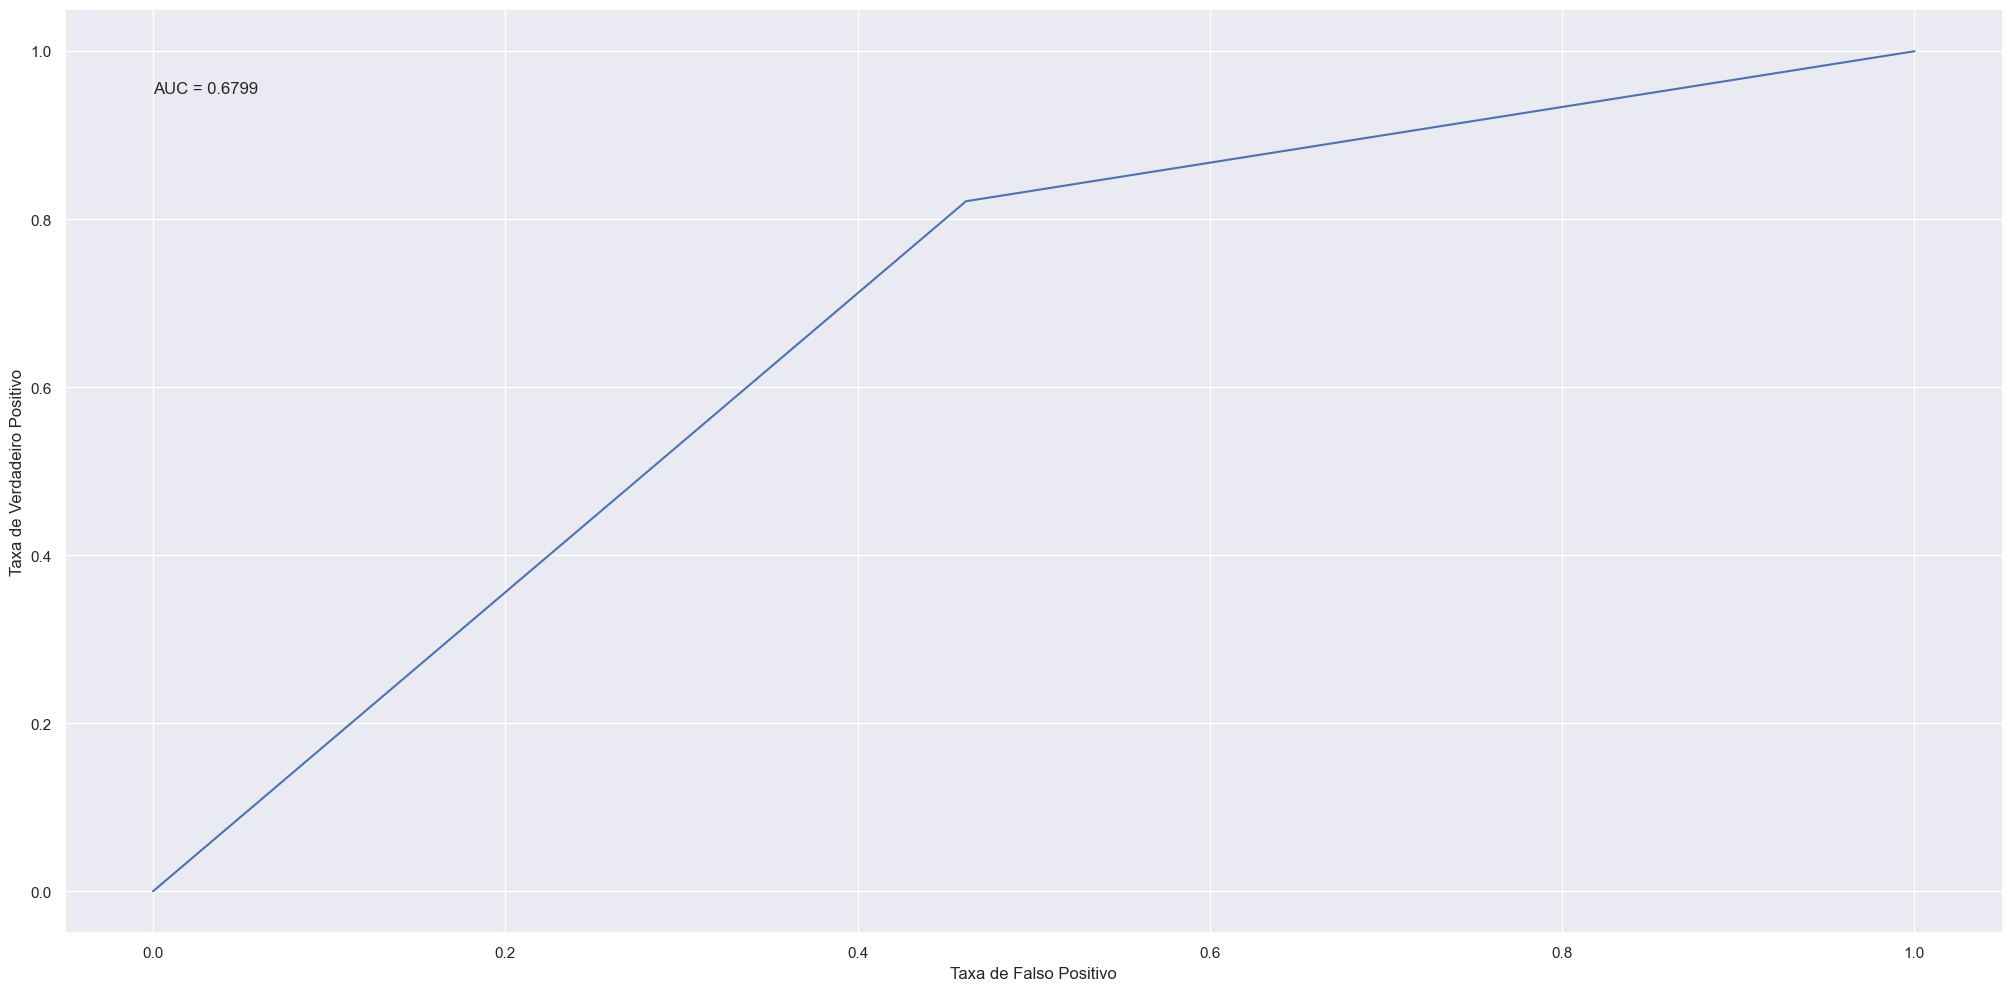

In [327]:
plt.plot(fpr, tpr)
plt.text(0.0, 0.95, "AUC = " + str(round(auc( fpr, tpr ),4)))
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.show();

In [328]:
thresholds

array([2, 1, 0])

In [902]:
clf.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 23, 100)           40800     
                                                                 
 lstm_101 (LSTM)             (None, 23, 100)           80400     
                                                                 
 lstm_102 (LSTM)             (None, 23, 100)           80400     
                                                                 
 lstm_103 (LSTM)             (None, 100)               80400     
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________
